# ユーティリティー・スケール実験 III

<Admonition type="note">
  Toshinari Itoko, Tamiya Onodera, Kifumi Numata (19 July 2024)

  [ここ](https://ibm.box.com/shared/static/fw1538dogvyv0qbfqg8tan1k2fs27mfv.zip)から元の講義資料をダウンロードできます。日本語版の講義資料は[こちら]()です。Qiskitの更新によって、コード・サンプルの中には今では非推奨となった機能を使っているものがあるかもしれないことをご容赦ください。

  *この実験を実行するのに使われる QPU時間はおよそ 12 分 30 秒です。最後の追加の実験には 4 分かかります。*

  (注: このノートブックは、オープンプランで許可されている時間内に評価されない場合があります。量子コンピューティングのリソースを賢く使用してください。)
</Admonition>



In [2]:
import qiskit

qiskit.__version__

'2.2.0'

In [3]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.__version__

'0.41.1'

In [5]:
import numpy as np
import rustworkx as rx

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_gate_map
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers import BackendV2
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler, Estimator, Batch, SamplerOptions

## 1. はじめに
GHZ 状態と、GHZ 状態に適用された`Sampler` からどのような分布が期待できるかを簡単に確認しましょう。次に、このレッスンの目標を明確に説明します。

### 1.1 GHZ 状態

$n$ 量子ビットの GHZ 状態 (Greenberger-Horne-Zeilinger 状態) は、次のように定義されます。

$$
\frac{1}{\sqrt 2}(|0\rangle ^ {\otimes n}+ |1\rangle^ {\otimes n})
$$

自然な形として、6 量子ビットのものを以下の回路で作ることができます。


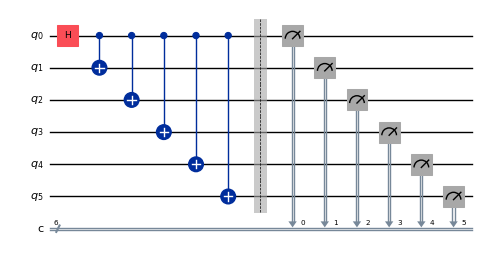

In [4]:
N = 6
qc = QuantumCircuit(N, N)

qc.h(0)
for i in range(N - 1):
    qc.cx(0, i + 1)

# qc.measure_all()
qc.barrier()
qc.measure(list(range(N)), list(range(N)))

qc.draw(output="mpl", idle_wires=False, scale=0.5)

In [5]:
print("Depth:", qc.depth())

Depth: 7


深さはそれほど大きくありませんが、以前のレッスンで学んだようにもう少し上手に作れることは分かっています。バックエンドを選んで、まずはこの回路をトランスパイルしましょう。

In [6]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
#backend = service.least_busy(operational=True, simulator=False)
backend.name
# or
# backend = service.least_busy(operational=True)
# backend.name

'ibm_brisbane'

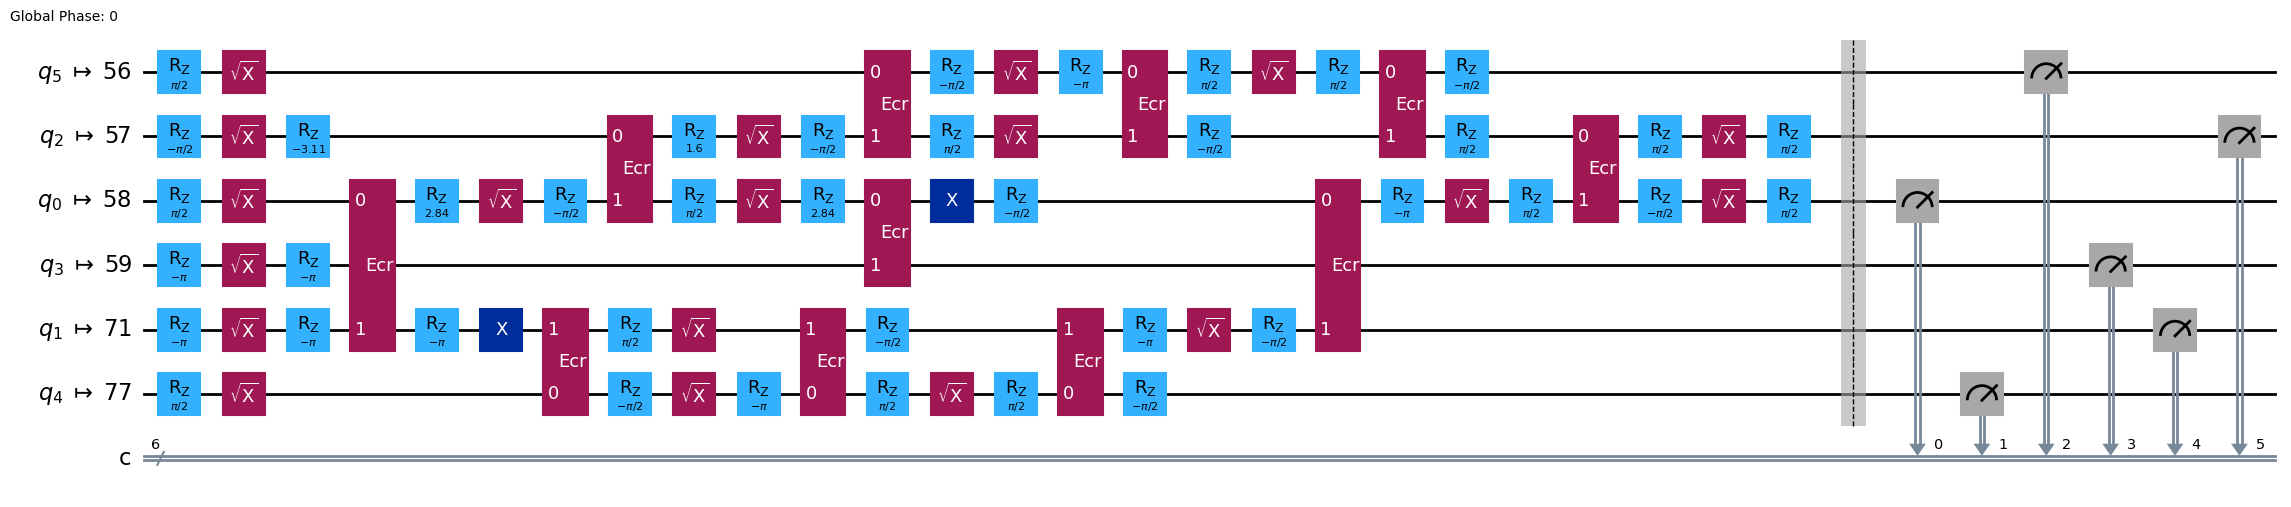

In [7]:
pm = generate_preset_pass_manager(3, backend=backend)
qc_transpiled = pm.run(qc)
qc_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [8]:
print("Depth:", qc_transpiled.depth())
print(
    "Two-qubit Depth:",
    qc_transpiled.depth(filter_function=lambda x: x.operation.num_qubits == 2),
)

Depth: 27
Two-qubit Depth: 6


ここでも、トランスパイルされた回路の 2 量子ビットの深さは大きすぎません。しかし、より多くの量子ビットでGHZ状態を扱うには、回路の最適化について明らかに考える必要があります。これを `Sampler` を使用して実行し、実際の量子コンピューターが何を返すか見てみましょう。


In [9]:
sampler = Sampler(mode=backend)
shots = 40000
job = sampler.run([qc_transpiled], shots=shots)
job_id = job.job_id()
print(job_id)

d3irk50dd19c738el5i0


In [10]:
job.status()

'DONE'

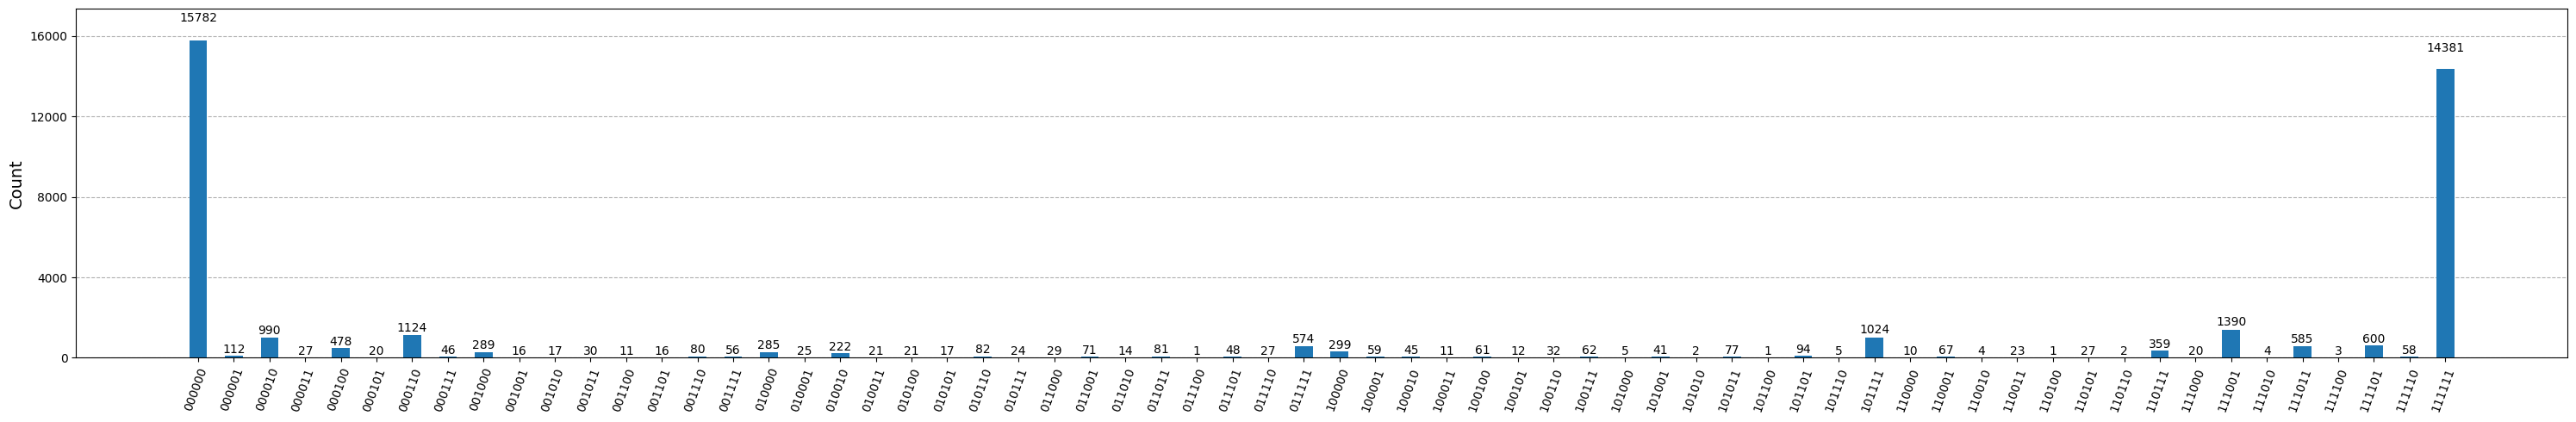

In [11]:
job = service.job(job_id)
result = job.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

これは6量子ビットGHZ回路の結果です。ご覧のとおり、すべての $|0\rangle$ とすべての $|1\rangle$ の状態が支配的ですが、誤差はかなり大きいです。Eagle デバイスでどれだけの大きさの GHZ 回路を作成できるかを確認しながら、状態の忠実度が少なくとも 50% を超える可能性が高い結果を得てみましょう。

### 1.2 目標

20 量子ビット以上の GHZ 回路を構築して、測定時に **GHZ 状態の忠実度が0.5より大きくなるように** します。
Note:

*   Eagle デバイス (`min_num_qubits=127`) を使用し、ショット数を40,000に設定する必要があります。
*   GHZ 回路の実行は `execute_ghz_fidelity` 関数で行い、忠実度は `check_ghz_fidelity_from_jobs` 関数で計算してください。

これは、このコースでこれまでに学んだことを活用する独立した演習として意図されています。

In [24]:
def execute_ghz_fidelity(
    ghz_circuit: QuantumCircuit,  # Quantum circuit to create GHZ state (Circuit after Routing or without Routing), Classical register name is "c"
    physical_qubits: list[int],  # Physical qubits to represent GHZ state
    backend: BackendV2,
    sampler_options: dict | SamplerOptions | None = None,
):
    N_SHOTS = 40_000
    N = len(physical_qubits)
    base_circuit = ghz_circuit.remove_final_measurements(inplace=False)
    # M_k measurement circuits
    mk_circuits = []
    for k in range(1, N + 1):
        circuit = base_circuit.copy()
        # change measurement basis
        for q in physical_qubits:
            circuit.rz(-k * np.pi / N, q)
            circuit.h(q)
        mk_circuits.append(circuit)

    obs = SparsePauliOp.from_sparse_list(
        [("Z" * N, physical_qubits, 1)], num_qubits=backend.num_qubits
    )
    job_ids = []
    pm1 = generate_preset_pass_manager(1, backend=backend)
    org_transpiled = pm1.run(ghz_circuit)
    mk_transpiled = pm1.run(mk_circuits)
    with Batch(backend=backend):
        sampler = Sampler(options=sampler_options)
        sampler.options.twirling.enable_measure = True
        job = sampler.run([org_transpiled], shots=N_SHOTS)
        job_ids.append(job.job_id())
        print(f"Sampler job id: {job.job_id()}, shots={N_SHOTS}")
        estimator = Estimator()  # TREX is applied as default
        estimator.options.dynamical_decoupling.enable = True
        estimator.options.execution.rep_delay = 0.0005
        estimator.options.twirling.enable_measure = True
        job2 = estimator.run([(circ, obs) for circ in mk_transpiled], precision=1 / 100)
        job_ids.append(job2.job_id())
        print("Estimator job id:", job2.job_id())
        return [job.job_id(), job2.job_id()]

In [25]:
def check_ghz_fidelity_from_jobs(
    sampler_job,
    estimator_job,
    num_qubits,
    shots=40_000,
):
    N = num_qubits
    sampler_result = sampler_job.result()
    counts = sampler_result[0].data.c.get_counts()
    all_zero = counts.get("0" * N, 0) / shots
    all_one = counts.get("1" * N, 0) / shots
    top3 = sorted(counts, key=counts.get, reverse=True)[:3]
    print(
        f"N={N}: |00..0>: {counts.get('0'*N, 0)}, |11..1>: {counts.get('1'*N, 0)}, |3rd>: {counts.get(top3[2], 0)} ({top3[2]})"
    )
    print(f"P(|00..0>)={all_zero}, P(|11..1>)={all_one}")

    estimator_result = estimator_job.result()
    non_diagonal = (1 / N) * sum(
        (-1) ** k * estimator_result[k - 1].data.evs for k in range(1, N + 1)
    )
    print(f"REM: Coherence (non-diagonal): {non_diagonal:.6f}")
    fidelity = 0.5 * (all_zero + all_one + non_diagonal)
    sigma = 0.5 * np.sqrt(
        (1 - all_zero - all_one) * (all_zero + all_one) / shots
        + sum(estimator_result[k].data.stds ** 2 for k in range(N)) / (N * N)
    )
    print(f"GHZ fidelity = {fidelity:.6f} ± {sigma:.6f}")
    if fidelity - 2 * sigma > 0.5:
        print("GME (genuinely multipartite entangled) test: Passed")
    else:
        print("GME (genuinely multipartite entangled) test: Failed")
    return {
        "fidelity": fidelity,
        "sigma": sigma,
        "shots": shots,
        "job_ids": [sampler_job.job_id(), estimator_job.job_id()],
    }

このノートブックでは、16量子ビットと30量子ビットを用いて良い GHZ 状態を作るための 3 つの戦略を紹介します。これらのアプローチは、以前のレッスンですでに学んだ戦略に基づいています。


## 2.戦略 1. ノイズを考慮した量子ビットの選択

まず、バックエンドを指定します。特定のバックエンドのプロパティを広範囲に操作するため、 `least_busy` オプションを使用するのではなく、1つのバックエンドを指定することをお勧めします。


In [14]:
backend = service.backend("ibm_brisbane")  # eagle
twoq_gate = "ecr"
print(f"Device {backend.name} Loaded with {backend.num_qubits} qubits")
print(f"Two Qubit Gate: {twoq_gate}")

Device ibm_brisbane Loaded with 127 qubits
Two Qubit Gate: ecr


私たちは、多くの2量子ビットのゲートを使った回路を構築しています。この 2 量子ビットゲートを実装するときに、誤差が最も少ない量子ビットを使用することは理にかなっています。2q ゲート・エラーの情報に基づいて最適な「量子ビット・チェーン」を見つけることは、自明な問題ではありません。以下のように最適な量子ビットを決定するための関数を定義しましょう。

In [15]:
coupling_map = backend.target.build_coupling_map(twoq_gate)
G = coupling_map.graph

In [16]:
def to_edges(path):  # create edges list from node paths
    edges = []
    prev_node = None
    for node in path:
        if prev_node is not None:
            if G.has_edge(prev_node, node):
                edges.append((prev_node, node))
            else:
                edges.append((node, prev_node))
        prev_node = node
    return edges


def path_fidelity(path, correct_by_duration: bool = True, readout_scale: float = None):
    """Compute an estimate of the total fidelity of 2-qubit gates on a path.
    If `correct_by_duration` is true, each gate fidelity is worsen by
    scale = max_duration / duration, that is, gate_fidelity^scale.
    If `readout_scale` > 0 is supplied, readout_fidelity^readout_scale
    for each qubit on the path is multiplied to the total fielity.
    The path is given in node indices form, for example, [0, 1, 2].
    An external function `to_edges` is used to obtain edge list, for example, [(0, 1), (1, 2)]."""
    path_edges = to_edges(path)
    max_duration = max(backend.target[twoq_gate][qs].duration for qs in path_edges)

    def gate_fidelity(qpair):
        duration = backend.target[twoq_gate][qpair].duration
        scale = max_duration / duration if correct_by_duration else 1.0
        # 1.25 = (d+1)/d with d = 4
        return max(0.25, 1 - (1.25 * backend.target[twoq_gate][qpair].error)) ** scale

    def readout_fidelity(qubit):
        return max(0.25, 1 - backend.target["measure"][(qubit,)].error)

    total_fidelity = np.prod(
        [gate_fidelity(qs) for qs in path_edges]
    )  # two qubits gate fidelity for each path
    if readout_scale:
        total_fidelity *= (
            np.prod([readout_fidelity(q) for q in path]) ** readout_scale
        )  # multiply readout fidelity
    return total_fidelity


def flatten(paths, cutoff=None):  # cutoff is for not making run time too large
    return [
        path
        for s, s_paths in paths.items()
        for t, st_paths in s_paths.items()
        for path in st_paths[:cutoff]
        if s < t
    ]

In [17]:
N = 16  # Number of qubits to use in the GHZ circuit
num_qubits_in_chain = N

上記の関数を使用して、グラフ内のすべてのノードペア間の N 量子ビットのすべてのパスを見つけます(参照:[all\_pairs\_all\_simple\_paths](https://www.rustworkx.org/apiref/rustworkx.all_pairs_all_simple_paths.html#rustworkx-all-pairs-all-simple-paths))。

次に、上記で作成した `path_fidelity` 関数を使用して、パスの忠実度が最も高い最適な量子ビット・チェーンを見つけます。



In [19]:
%%time
from functools import partial

paths = rx.all_pairs_all_simple_paths(
    G.to_undirected(multigraph=False),
    min_depth=num_qubits_in_chain,
    cutoff=num_qubits_in_chain,
)
paths = flatten(paths, cutoff=25)  # If you have time, you could set a larger cutoff.
if not paths:
    raise Exception(
        f"No qubit chain with length={num_qubits_in_chain} exists in {backend.name}. Try smaller num_qubits_in_chain."
    )

print(f"Selecting the best from {len(paths)} candidate paths")

best_qubit_chain = max(
    paths, key=partial(path_fidelity, correct_by_duration=True, readout_scale=1.0)
)
assert len(best_qubit_chain) == num_qubits_in_chain
print(f"Predicted (best possible) process fidelity: {path_fidelity(best_qubit_chain)}")

Selecting the best from 6046 candidate paths
Predicted (best possible) process fidelity: 0.8980927432520546
CPU times: user 228 ms, sys: 9.71 ms, total: 238 ms
Wall time: 242 ms


In [20]:
np.array(best_qubit_chain)

array([64, 63, 62, 61, 60, 53, 41, 40, 39, 38, 37, 52, 56, 57, 58, 71],
      dtype=uint64)

最適な量子ビット・チェーンをピンク色でカップリング・マップの図にプロットしてみましょう。

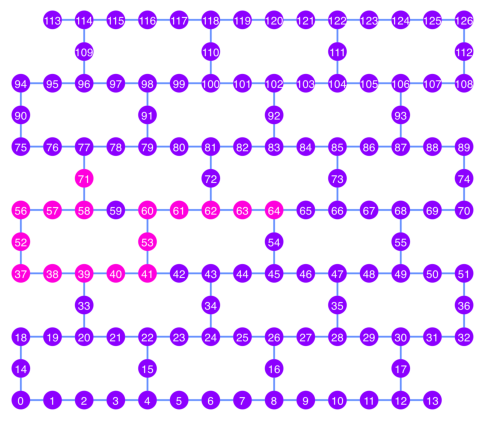

In [21]:
qubit_color = []
for i in range(133):
    if i in best_qubit_chain:
        qubit_color.append("#ff00dd")  # pink
    else:
        qubit_color.append("#8c00ff")  # purple
plot_gate_map(
    backend, qubit_color=qubit_color, qubit_size=50, font_size=25, figsize=(6, 6)
)

### 2.1 最も良い量子ビット・チェーン上にGHZ回路を構築する

チェーンの中央にある量子ビットを選択して、最初に H ゲートを適用します。これで回路の深さが約半分に減少するはずです。



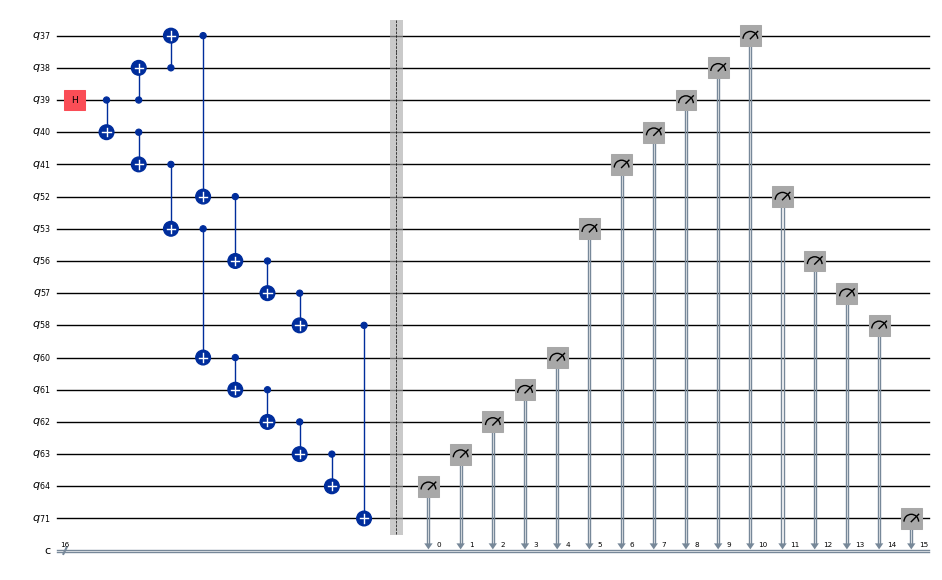

In [22]:
ghz1 = QuantumCircuit(max(best_qubit_chain) + 1, N)
ghz1.h(best_qubit_chain[N // 2])
for i in range(N // 2, 0, -1):
    ghz1.cx(best_qubit_chain[i], best_qubit_chain[i - 1])
for i in range(N // 2, N - 1, +1):
    ghz1.cx(best_qubit_chain[i], best_qubit_chain[i + 1])
ghz1.barrier()  # for visualization
ghz1.measure(best_qubit_chain, list(range(N)))
ghz1.draw(output="mpl", idle_wires=False, scale=0.5, fold=-1)

In [23]:
ghz1.depth()

10

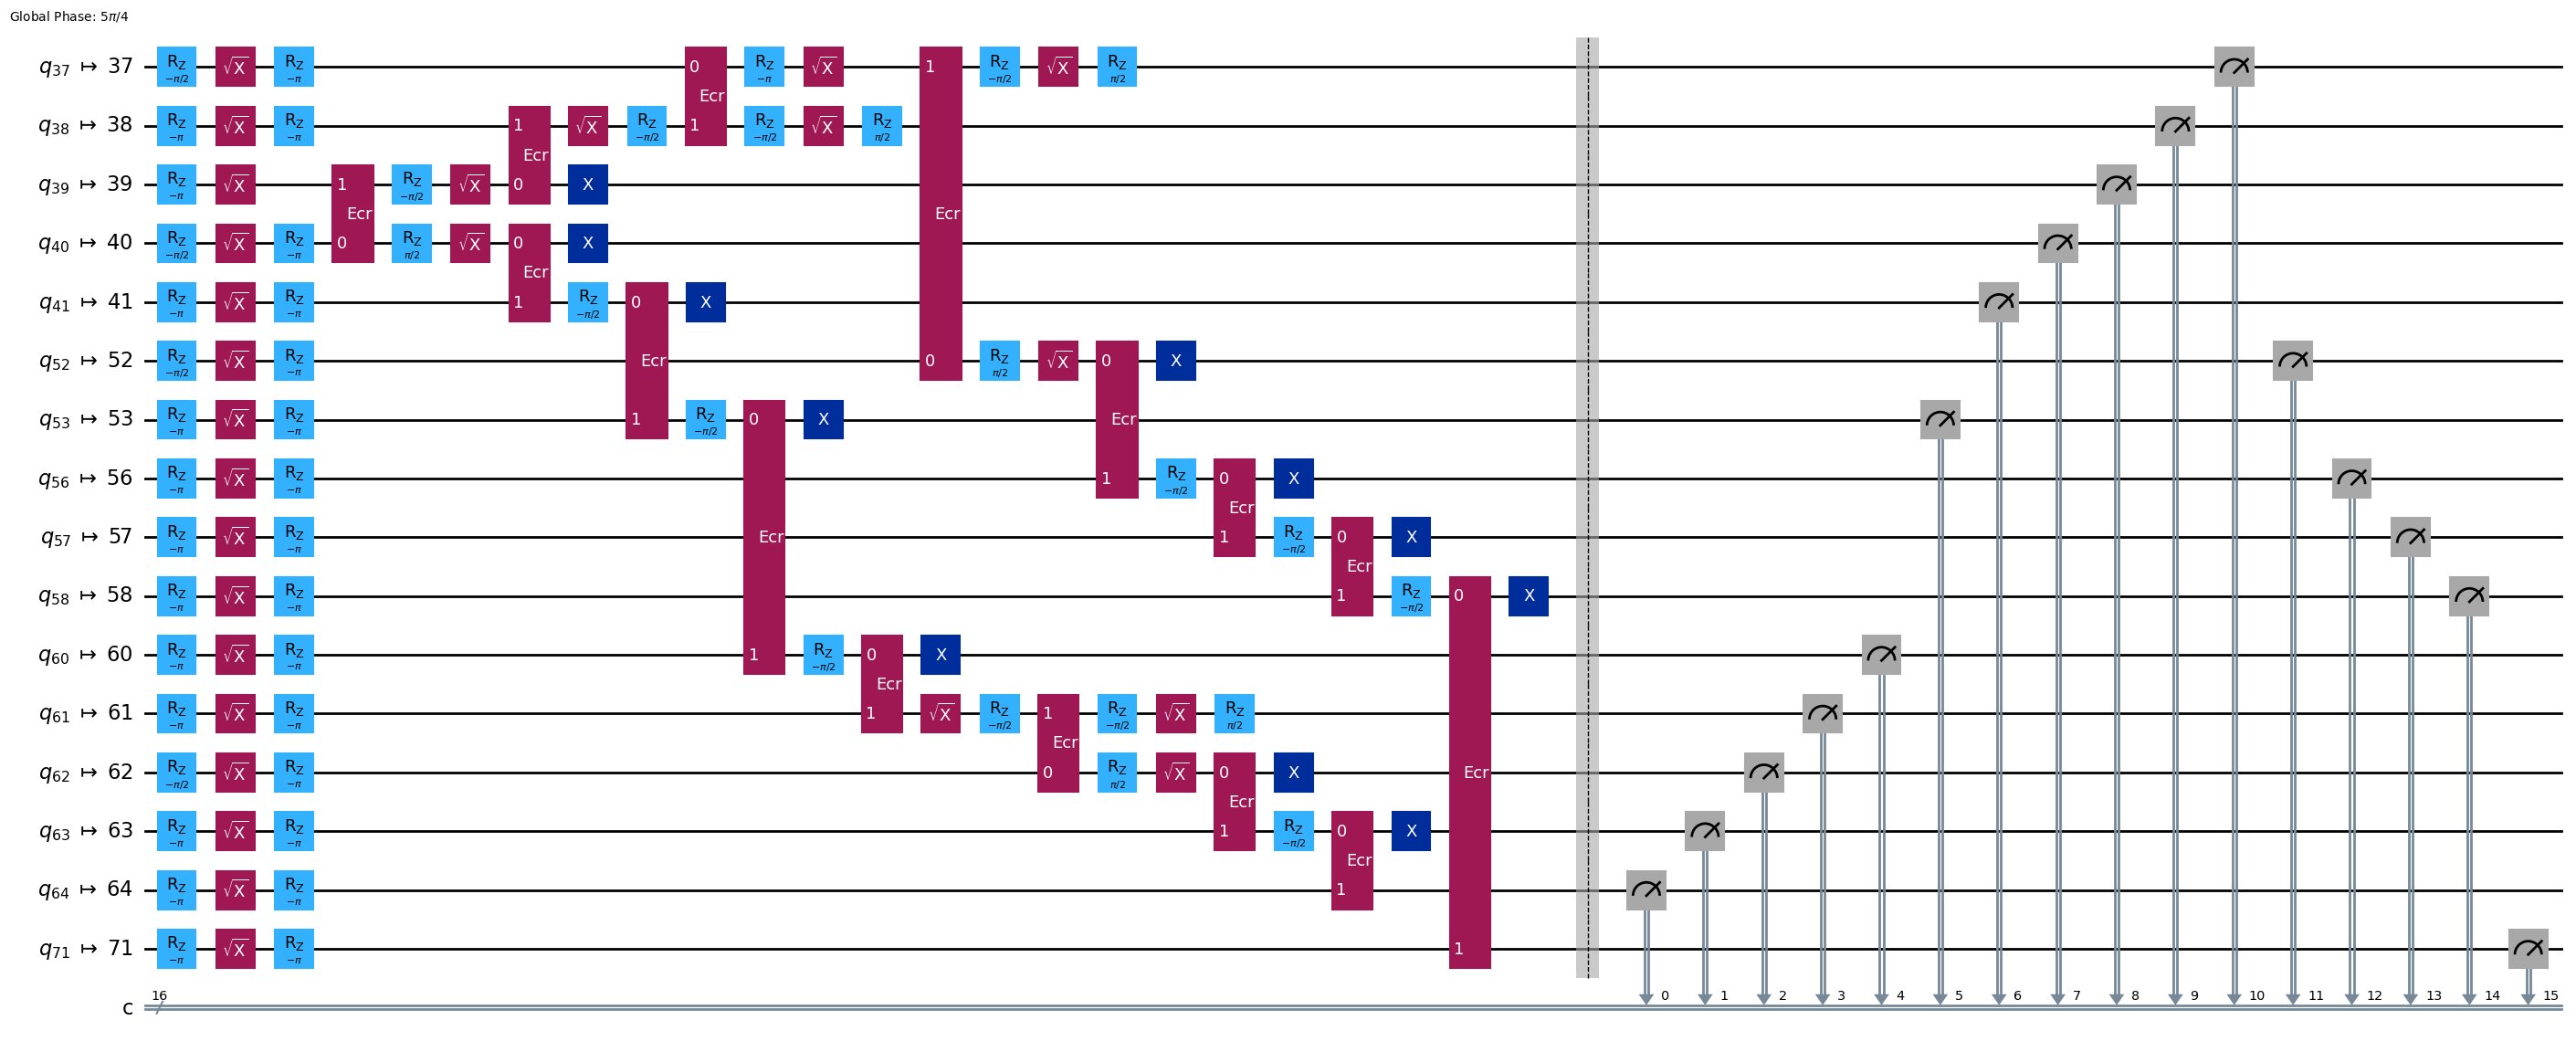

In [24]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz1_transpiled = pm.run(ghz1)
ghz1_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [25]:
print("Depth:", ghz1_transpiled.depth())
print(
    "Two-qubit Depth:",
    ghz1_transpiled.depth(filter_function=lambda x: x.operation.num_qubits == 2),
)

Depth: 24
Two-qubit Depth: 8


In [26]:
opts = SamplerOptions()

In [27]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz1,
    physical_qubits=best_qubit_chain,
    backend=backend,
    sampler_options=opts,
)

In [30]:
job_s = service.job(res[0])  # Use your job id showed above.
job_e = service.job(res[1])
print(job_s.status(), job_e.status())

DONE DONE


上記のジョブのステータスが 'DONE' になった後に次のセルを実行し、 `check_ghz_fidelity_from_jobs` 関数を使用して結果を表示してください。

In [31]:
N = 16
# Check fidelity from job IDs
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

N=16: |00..0>: 1727, |11..1>: 10086, |3rd>: 1957 (0000011000000000)
P(|00..0>)=0.043175, P(|11..1>)=0.25215
REM: Coherence (non-diagonal): 0.336718
GHZ fidelity = 0.316022 ± 0.002298
GME (genuinely multipartite entangled) test: Failed


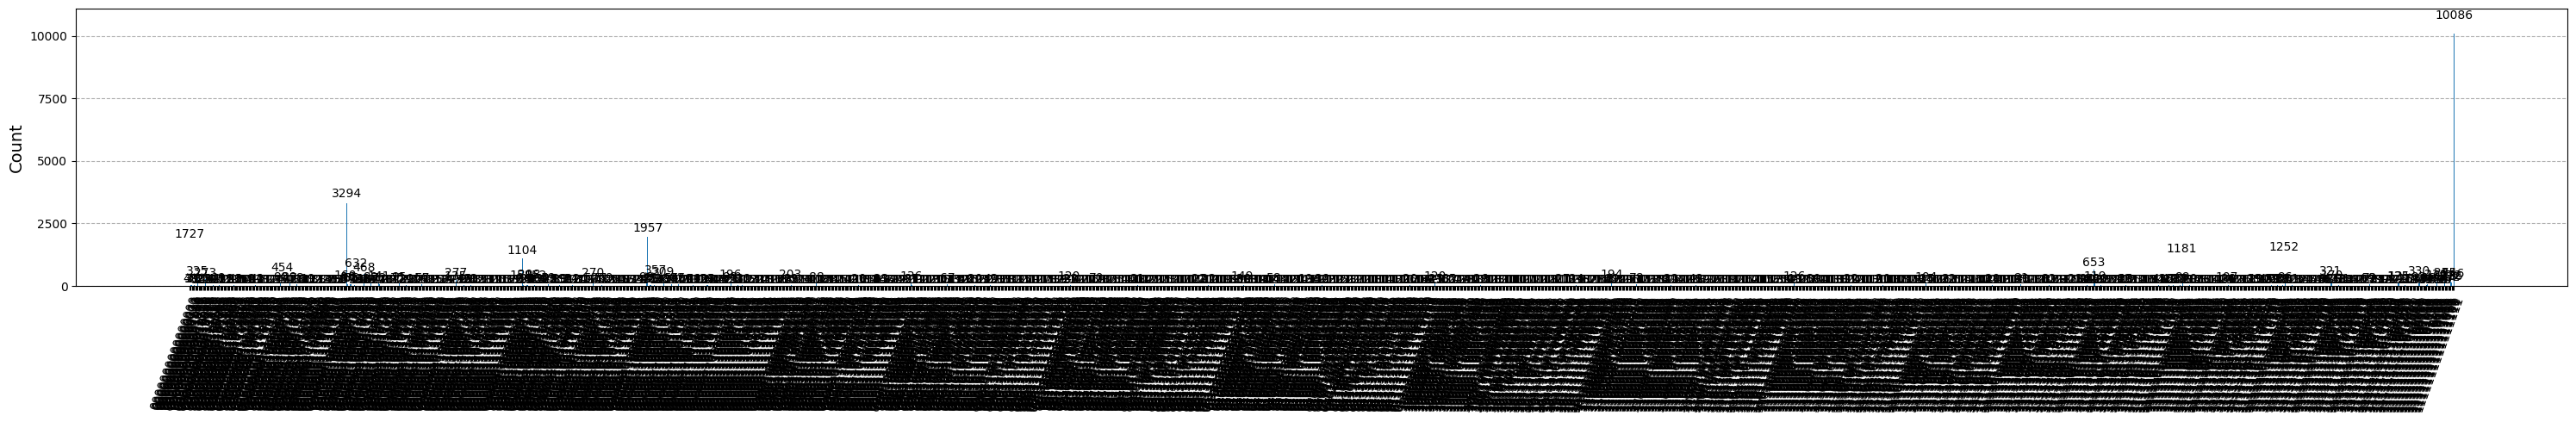

In [32]:
result = job_s.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

この結果はクライテリアを満たしていません。次のアイデアに移りましょう。

## 3.戦略 2. 量子ビットのバランスツリー
次のアイデアは、量子ビットのバランスの取れたツリーを見つけることです。チェーン形状ではなくツリーの形を使用すると、回路の深さが低くなるはずです。先に、読み出しエラーが "bad" のノードとゲートエラーが "bad" のエッジを結合グラフから削除します。


In [33]:
BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_ECRGATE_ERROR_THRESHOLD = 0.1
bad_readout_qubits = [
    q
    for q in range(backend.num_qubits)
    if backend.target["measure"][(q,)].error > BAD_READOUT_ERROR_THRESHOLD
]
bad_ecrgate_edges = [
    qpair
    for qpair in backend.target["ecr"]
    if backend.target["ecr"][qpair].error > BAD_ECRGATE_ERROR_THRESHOLD
]
print("Bad readout qubits:", bad_readout_qubits)
print("Bad ECR gates:", bad_ecrgate_edges)

Bad readout qubits: [17, 24, 67, 68, 74, 106]
Bad ECR gates: [(24, 34), (85, 84)]


In [34]:
g = backend.coupling_map.graph.copy().to_undirected()
g.remove_edges_from(
    bad_ecrgate_edges
)  # remove edge first (otherwise might fail with a NoEdgeBetweenNodes error)
g.remove_nodes_from(bad_readout_qubits)

悪いエッジと悪い量子ビットを除いたカップリング・マップの図を描いてみましょう。


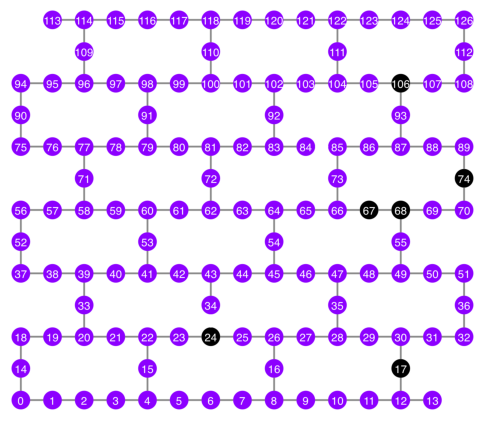

In [35]:
qubit_color = []
for i in range(133):
    if i in bad_readout_qubits:
        qubit_color.append("#000000")  # black
    else:
        qubit_color.append("#8c00ff")  # purple
line_color = []
for e in backend.target.build_coupling_map().get_edges():
    if e in bad_ecrgate_edges:
        line_color.append("#ffffff")  # white
    else:
        line_color.append("#888888")  # gray
plot_gate_map(
    backend,
    qubit_color=qubit_color,
    line_color=line_color,
    qubit_size=50,
    font_size=25,
    figsize=(6, 6),
)

先程と同じように 16 量子ビットの GHZ 状態を作成しします。


In [36]:
N = 16

 `betweenness_centrality` 関数を呼び出して、ルート・ノードとなる量子ビットを見つけます。媒介中心性 (Betweenness Centrality) の値が最も高いノードは、グラフの中央にあります。参考:[https://www.rustworkx.org/tutorial/betweenness\_centrality.html](https://www.rustworkx.org/tutorial/betweenness_centrality.html)

または、ルート・ノードを手動で選択することもできます。


In [37]:
# central = 65 #Select the center node manually
c_degree = dict(rx.betweenness_centrality(g))
central = max(c_degree, key=c_degree.get)
central

62

ルート・ノードから始めて、幅優先検索 (Breadth First Search, BFS) でツリーを生成します。参考:[https://qiskit.org/ecosystem/rustworkx/apiref/rustworkx.bfs\_search.html#rustworkx-bfs-search](https://qiskit.org/ecosystem/rustworkx/apiref/rustworkx.bfs_search.html#rustworkx-bfs-search)

In [38]:
class TreeEdgesRecorder(rx.visit.BFSVisitor):
    def __init__(self, N):
        self.edges = []
        self.N = N

    def tree_edge(self, edge):
        self.edges.append(edge)
        if len(self.edges) >= self.N - 1:
            raise rx.visit.StopSearch()


vis = TreeEdgesRecorder(N)
rx.bfs_search(g, [central], vis)
best_qubits = sorted(list(set(q for e in vis.edges for q in (e[0], e[1]))))
# print('Tree edges:', vis.edges)

In [39]:
print("Qubits selected:", best_qubits)

Qubits selected: [53, 54, 59, 60, 61, 62, 63, 64, 65, 66, 72, 79, 80, 81, 82, 83]


選択した量子ビットをピンク色でカップリング・マップの図にプロットしてみましょう。

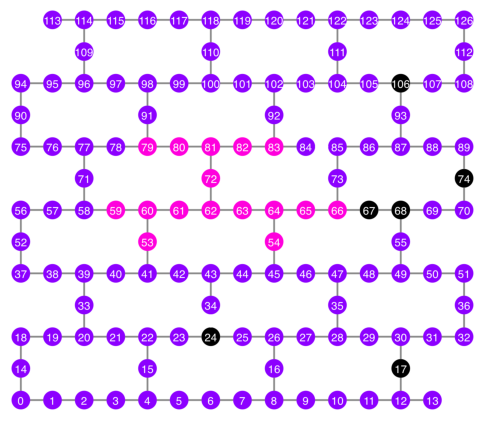

In [40]:
qubit_color = []
for i in range(133):
    if i in bad_readout_qubits:
        qubit_color.append("#000000")  # black
    elif i in best_qubits:
        qubit_color.append("#ff00dd")  # pink
    else:
        qubit_color.append("#8c00ff")  # purple
plot_gate_map(
    backend,
    qubit_color=qubit_color,
    line_color=line_color,
    qubit_size=50,
    font_size=25,
    figsize=(6, 6),
)

量子ビットのツリー構造を示してみましょう。

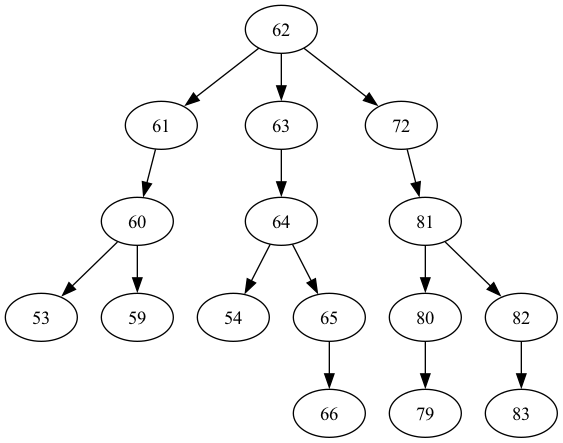

In [41]:
from rustworkx.visualization import graphviz_draw

tree = rx.PyDiGraph()
tree.extend_from_weighted_edge_list(vis.edges)
tree.remove_nodes_from([n for n in range(max(best_qubits) + 1) if n not in best_qubits])

graphviz_draw(tree, method="dot")

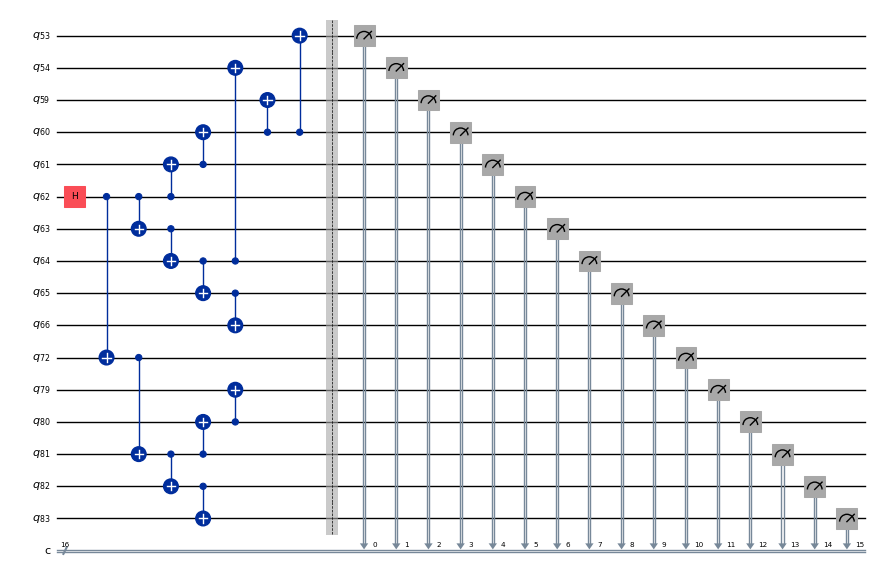

In [42]:
ghz2 = QuantumCircuit(max(best_qubits) + 1, N)

ghz2.h(tree.edge_list()[0][0])  # apply H-gate to the root node
# Apply CNOT from the root node to the each edge.
for u, v in tree.edge_list():
    ghz2.cx(u, v)
ghz2.barrier()  # for visualization
ghz2.measure(best_qubits, list(range(N)))
ghz2.draw(output="mpl", idle_wires=False, scale=0.5)

In [43]:
ghz2.depth()

8

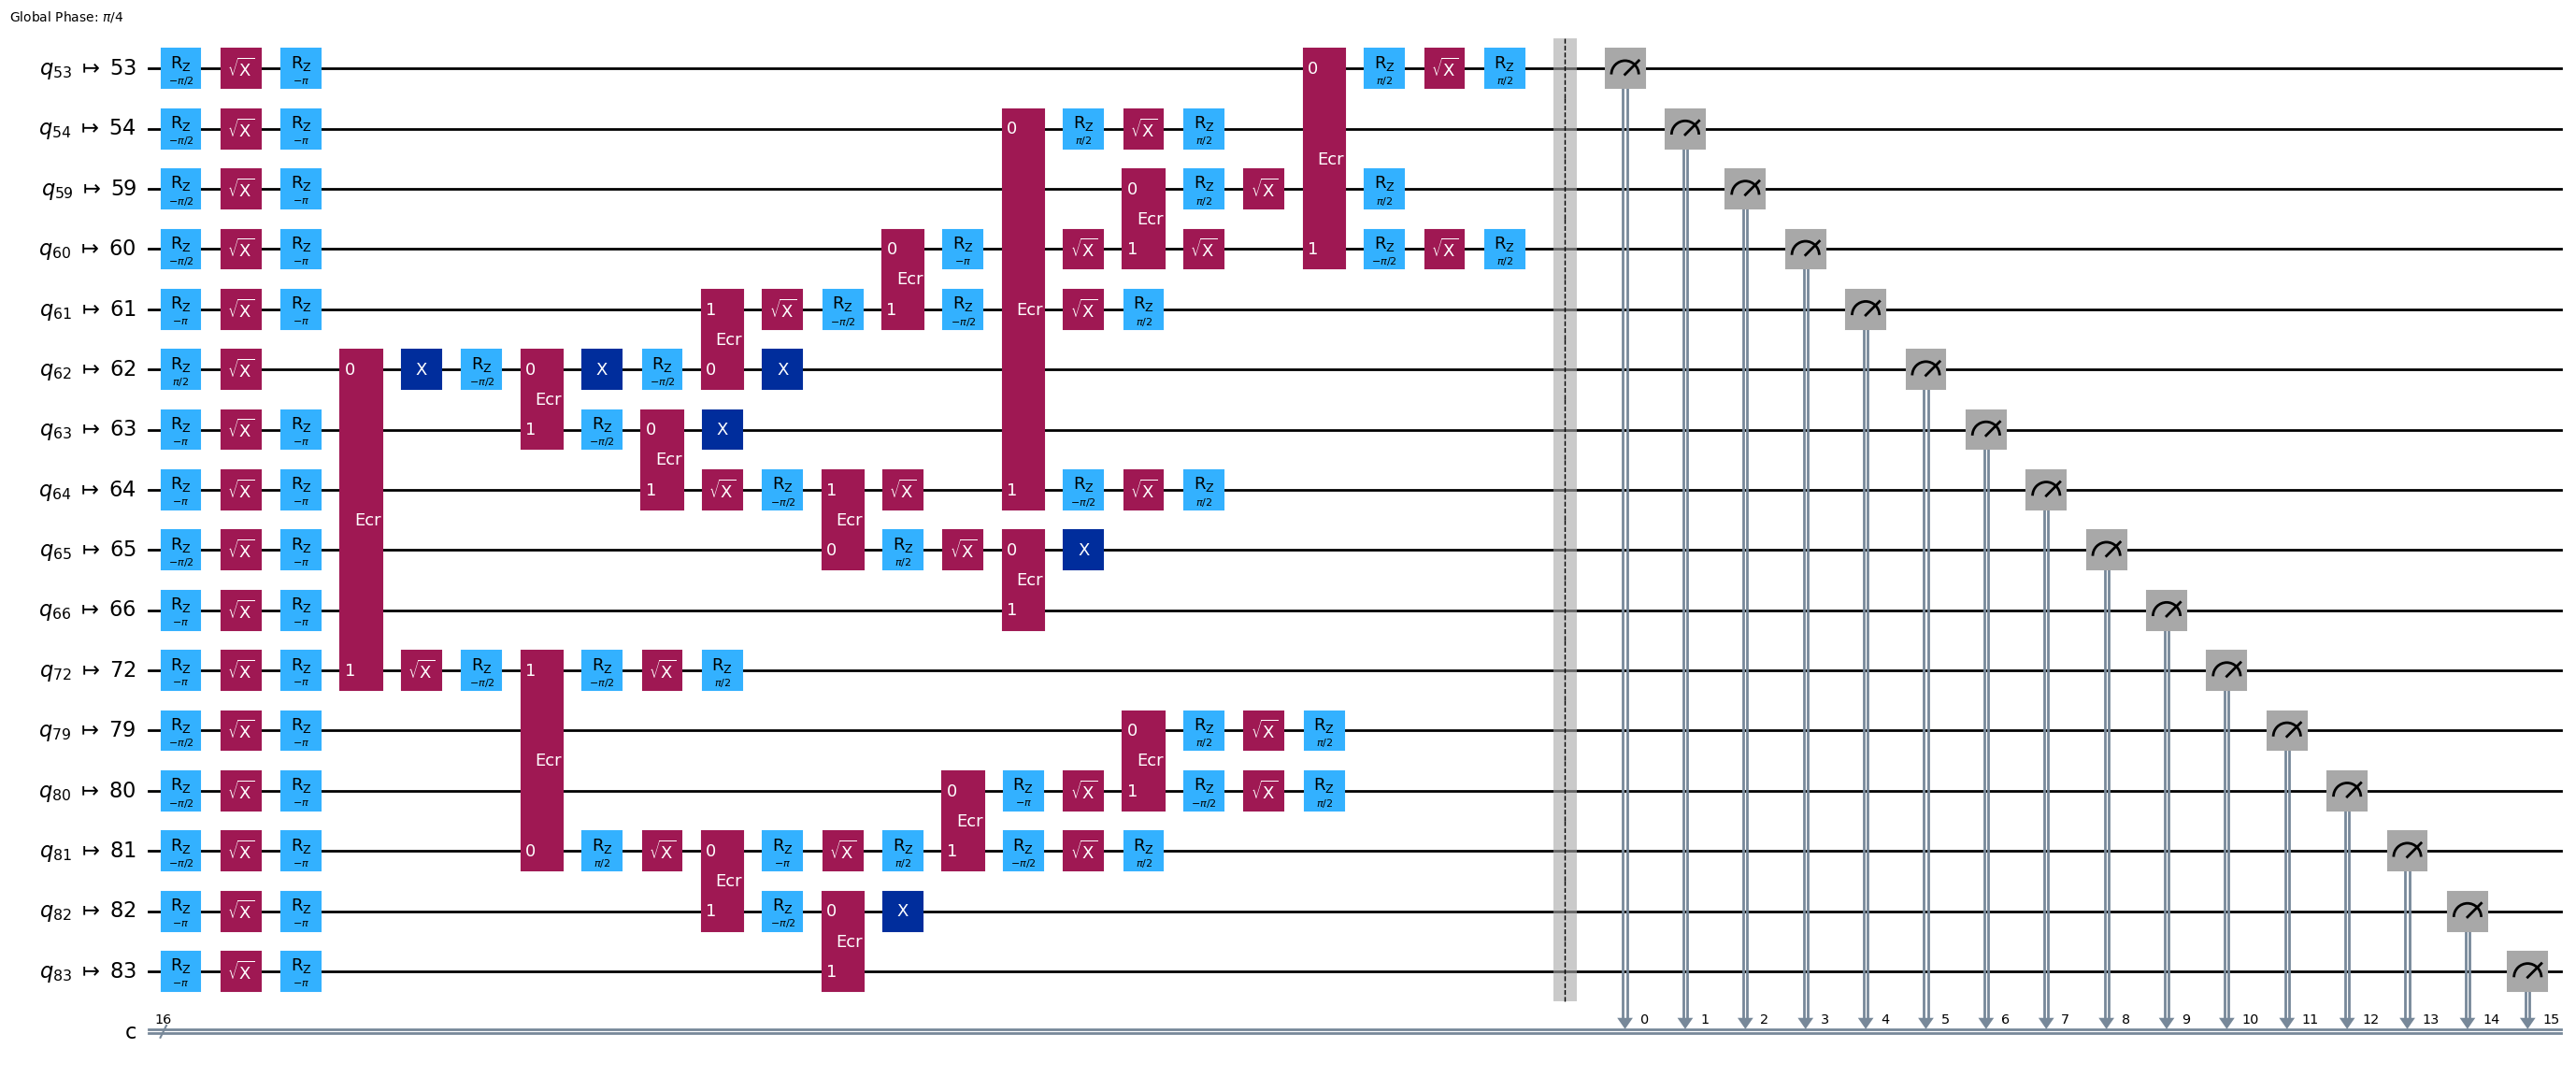

In [44]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz2_transpiled = pm.run(ghz2)
ghz2_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [45]:
print("Depth:", ghz2_transpiled.depth())
print(
    "Two-qubit Depth:",
    ghz2_transpiled.depth(filter_function=lambda x: x.operation.num_qubits == 2),
)

Depth: 22
Two-qubit Depth: 6


回路の深さは、チェーン構造のときの深さよりもはるかに低くなりました。

In [46]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz2,
    physical_qubits=best_qubits,
    backend=backend,
    sampler_options=opts,
)

Sampler job id: d3irnao3qtks73888h4g, shots=40000
Estimator job id: d3irnb0dd19c738el8og


In [47]:
job_s = service.job(res[0])  # Use your job id showed above.
job_e = service.job(res[1])
print(job_s.status(), job_e.status())

DONE DONE


In [48]:
N = 16
# Check fidelity from job IDs
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

N=16: |00..0>: 6195, |11..1>: 9117, |3rd>: 2541 (0000010000000000)
P(|00..0>)=0.154875, P(|11..1>)=0.227925
REM: Coherence (non-diagonal): 0.582622
GHZ fidelity = 0.482711 ± 0.002649
GME (genuinely multipartite entangled) test: Failed


バランスの取れたツリー構造でクライテリアをパスしました！（そのときのデバイスのコンデイションによります。）

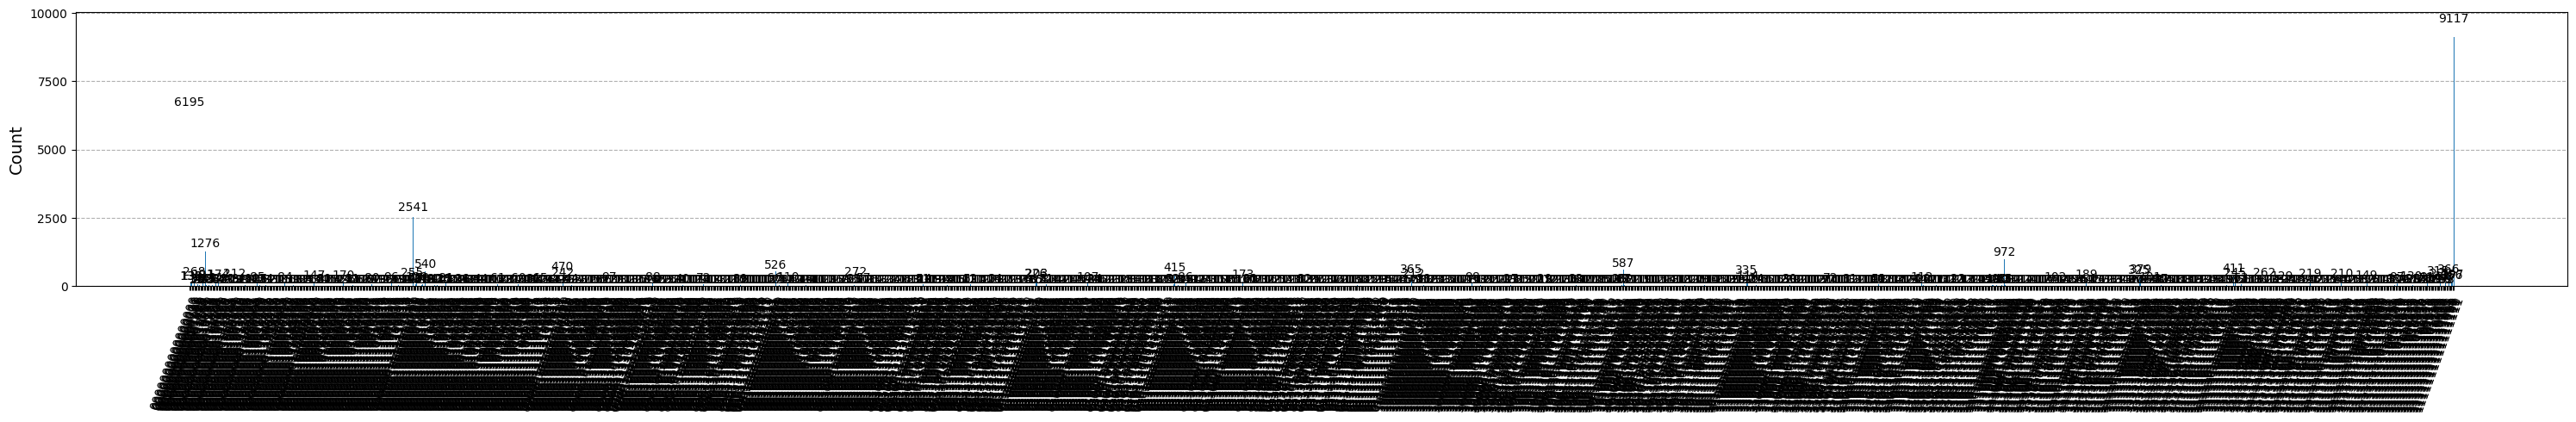

In [49]:
result = job_s.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

それでは、より大きな GHZ 状態、つまり 30 量子ビットの GHZ 状態を作ってみましょう。

### 3.1 N = 30

[Qiskit patterns](https://quantum.cloud.ibm.com/docs/en/guides/intro-to-patterns) のフレームワークに従います。

* ステップ 1: 問題の量子回路と演算子へのマッピング
* ステップ 2: ターゲット・ハードウェアに対する最適化
* ステップ 3: ターゲット・ハードウェアで実行
* ステップ 4: 結果の後処理

#### ステップ 1: 問題を量子回路と演算子にマッピングし、ステップ 2: ターゲット・ハードウェアに対して最適化する

ここでは、ルート・ノードを手動で選択します。


In [50]:
central = 62  # Select the center node manually
# c_degree = dict(rx.betweenness_centrality(g))
# central = max(c_degree, key=c_degree.get)
# central

In [51]:
N = 30

vis = TreeEdgesRecorder(N)
rx.bfs_search(g, [central], vis)
best_qubits = sorted(list(set(q for e in vis.edges for q in (e[0], e[1]))))
print("Qubits selected:", best_qubits)

Qubits selected: [40, 41, 42, 44, 45, 46, 53, 54, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 71, 72, 73, 78, 79, 80, 81, 82, 83, 84, 91, 92]


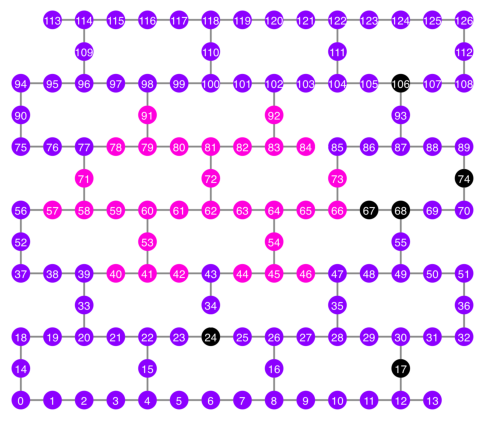

In [52]:
qubit_color = []
for i in range(133):
    if i in bad_readout_qubits:
        qubit_color.append("#000000")
    elif i in best_qubits:
        qubit_color.append("#ff00dd")
    else:
        qubit_color.append("#8c00ff")
line_color = []
for e in backend.target.build_coupling_map().get_edges():
    if e in bad_ecrgate_edges:
        line_color.append("#ffffff")
    else:
        line_color.append("#888888")
plot_gate_map(
    backend,
    qubit_color=qubit_color,
    line_color=line_color,
    qubit_size=50,
    font_size=25,
    figsize=(6, 6),
)

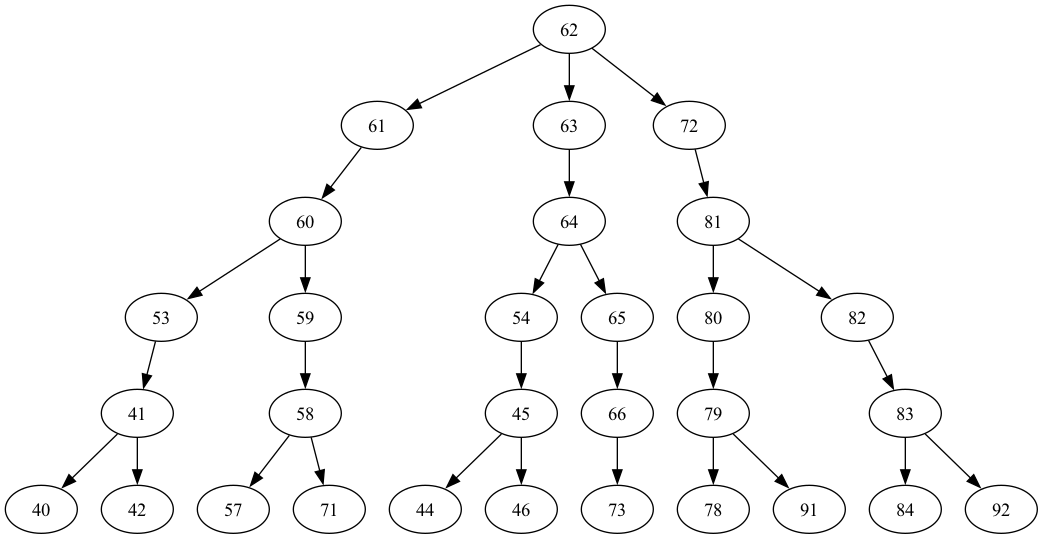

In [53]:
from rustworkx.visualization import graphviz_draw

tree = rx.PyDiGraph()
tree.extend_from_weighted_edge_list(vis.edges)
tree.remove_nodes_from([n for n in range(max(best_qubits) + 1) if n not in best_qubits])

graphviz_draw(tree, method="dot")


このツリーの深さは5です。

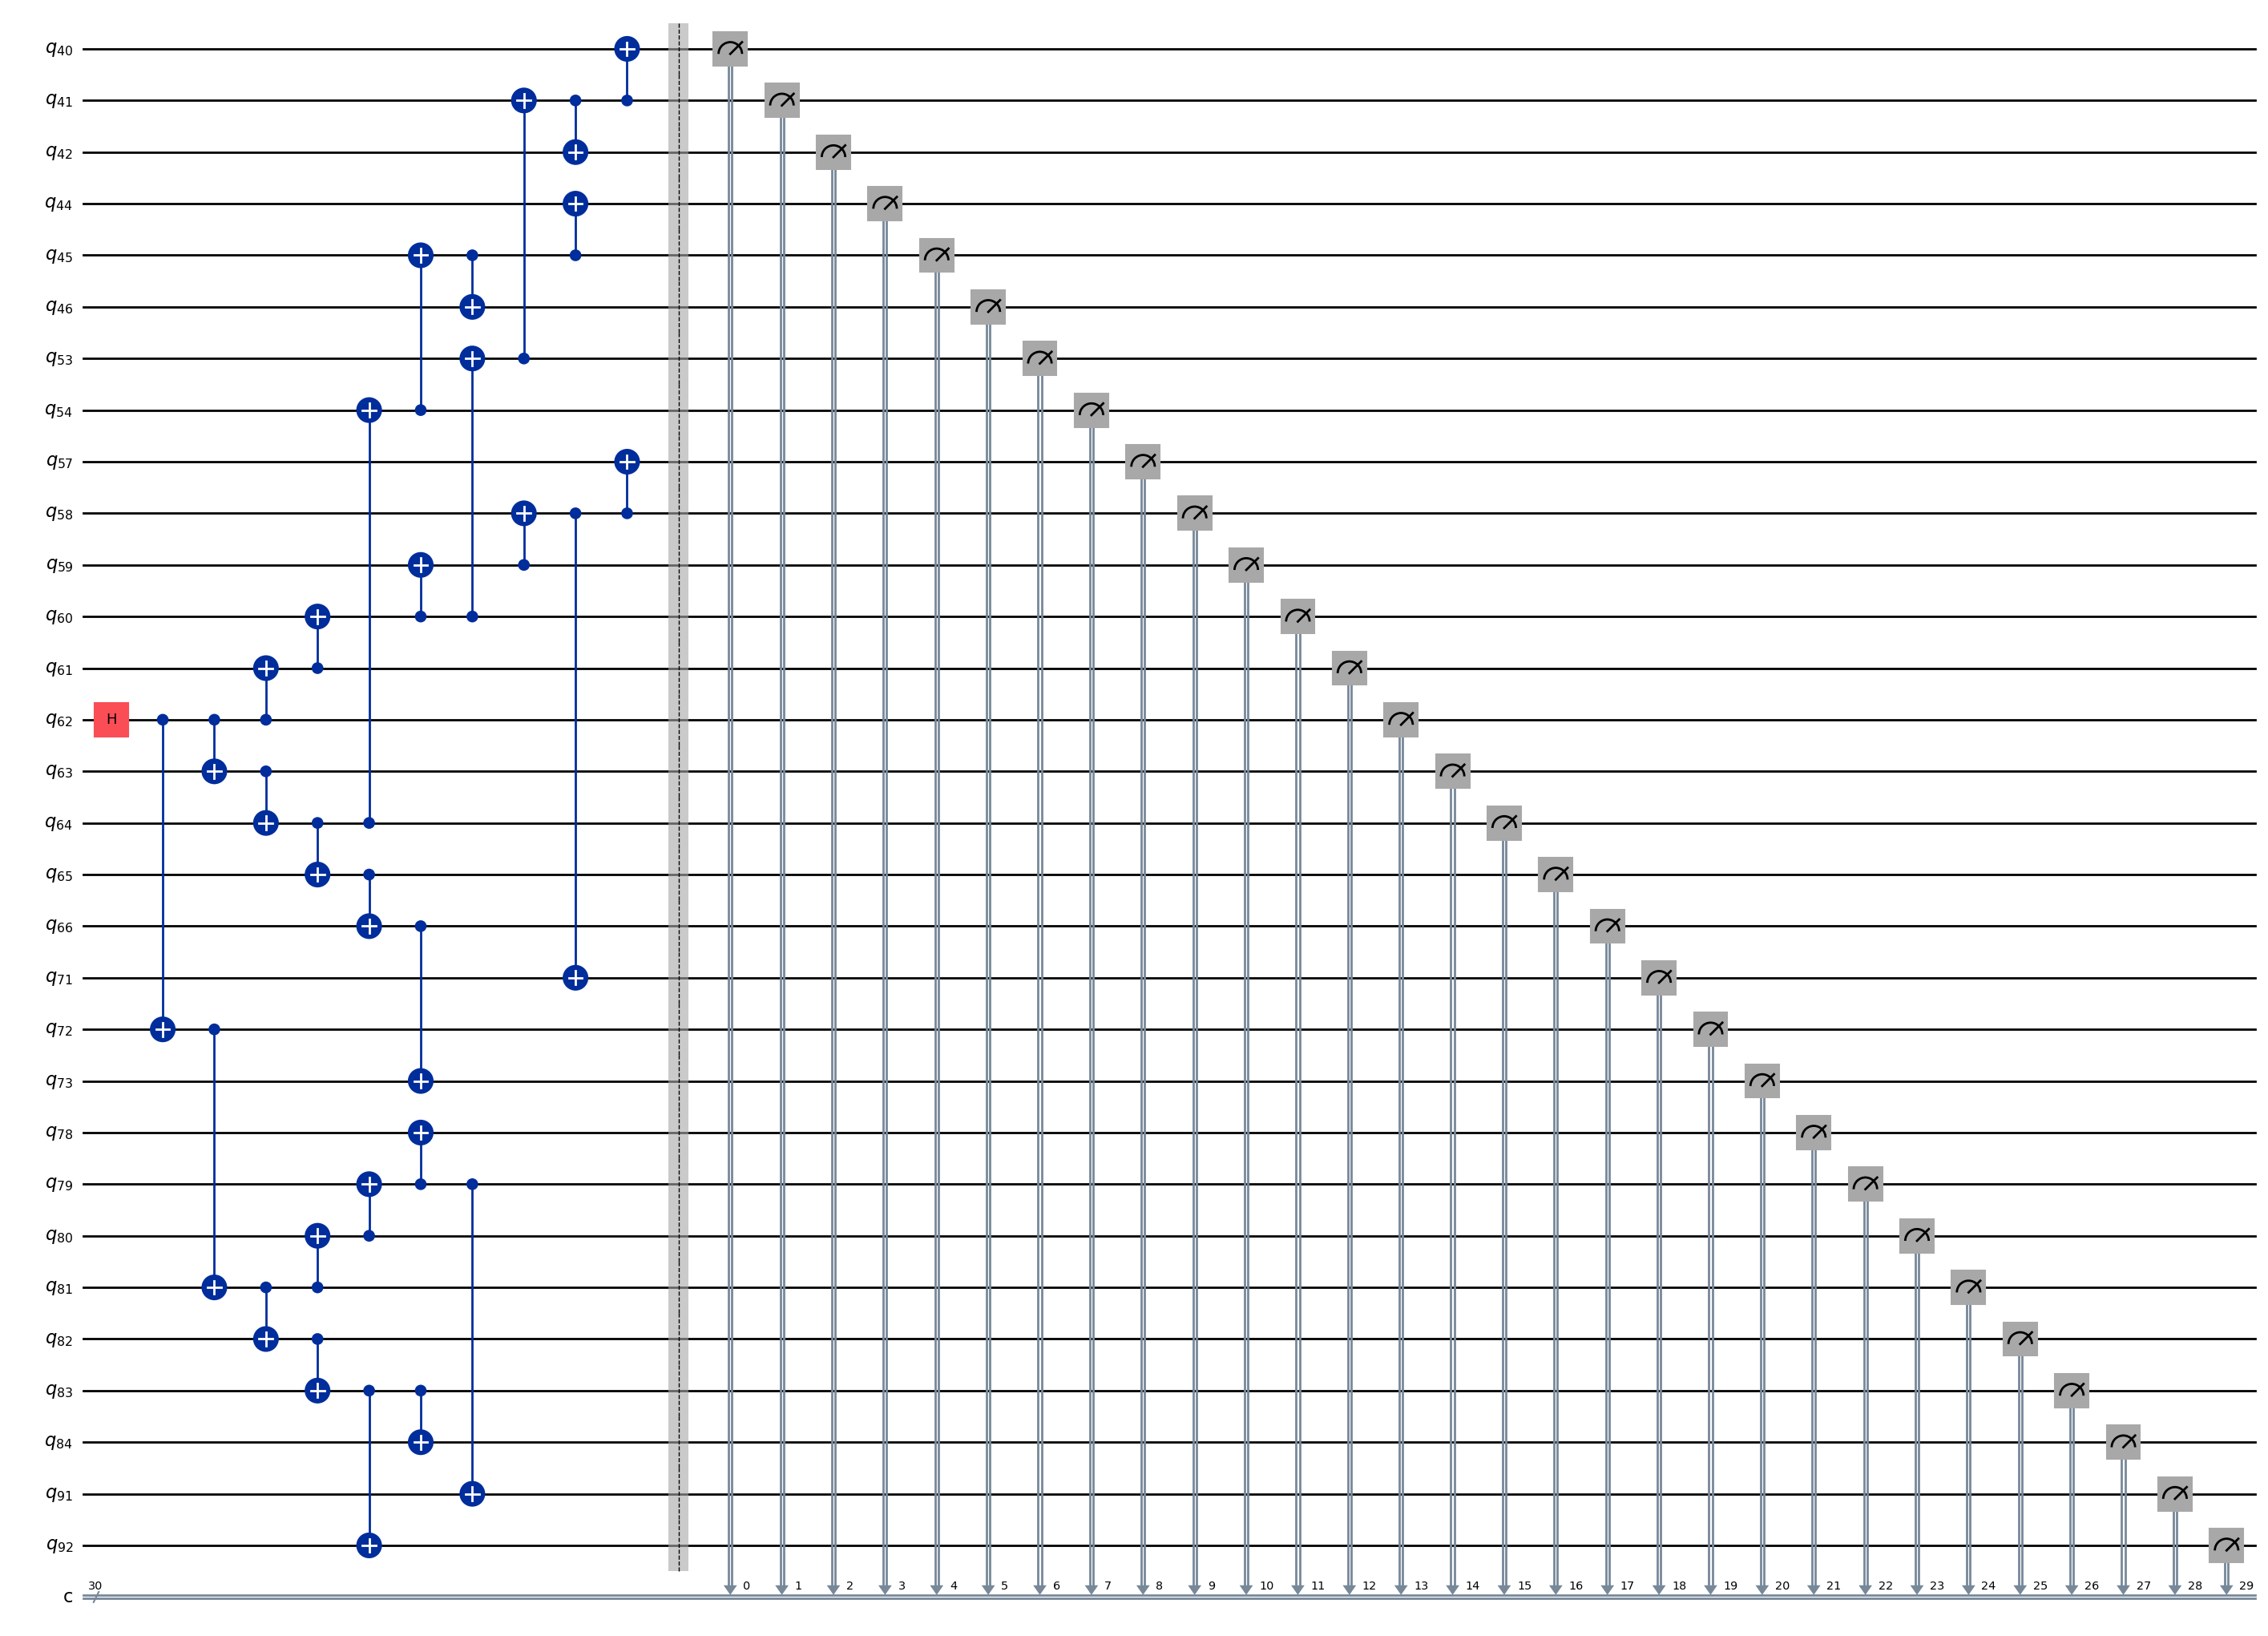

In [54]:
ghz3 = QuantumCircuit(max(best_qubits) + 1, N)

ghz3.h(tree.edge_list()[0][0])  # apply H-gate to the root node
# Apply CNOT from the root node to the each edge.
for u, v in tree.edge_list():
    ghz3.cx(u, v)
ghz3.barrier()  # for visualization
ghz3.measure(best_qubits, list(range(N)))
ghz3.draw(output="mpl", idle_wires=False, fold=-1)

In [55]:
ghz3.depth()

11

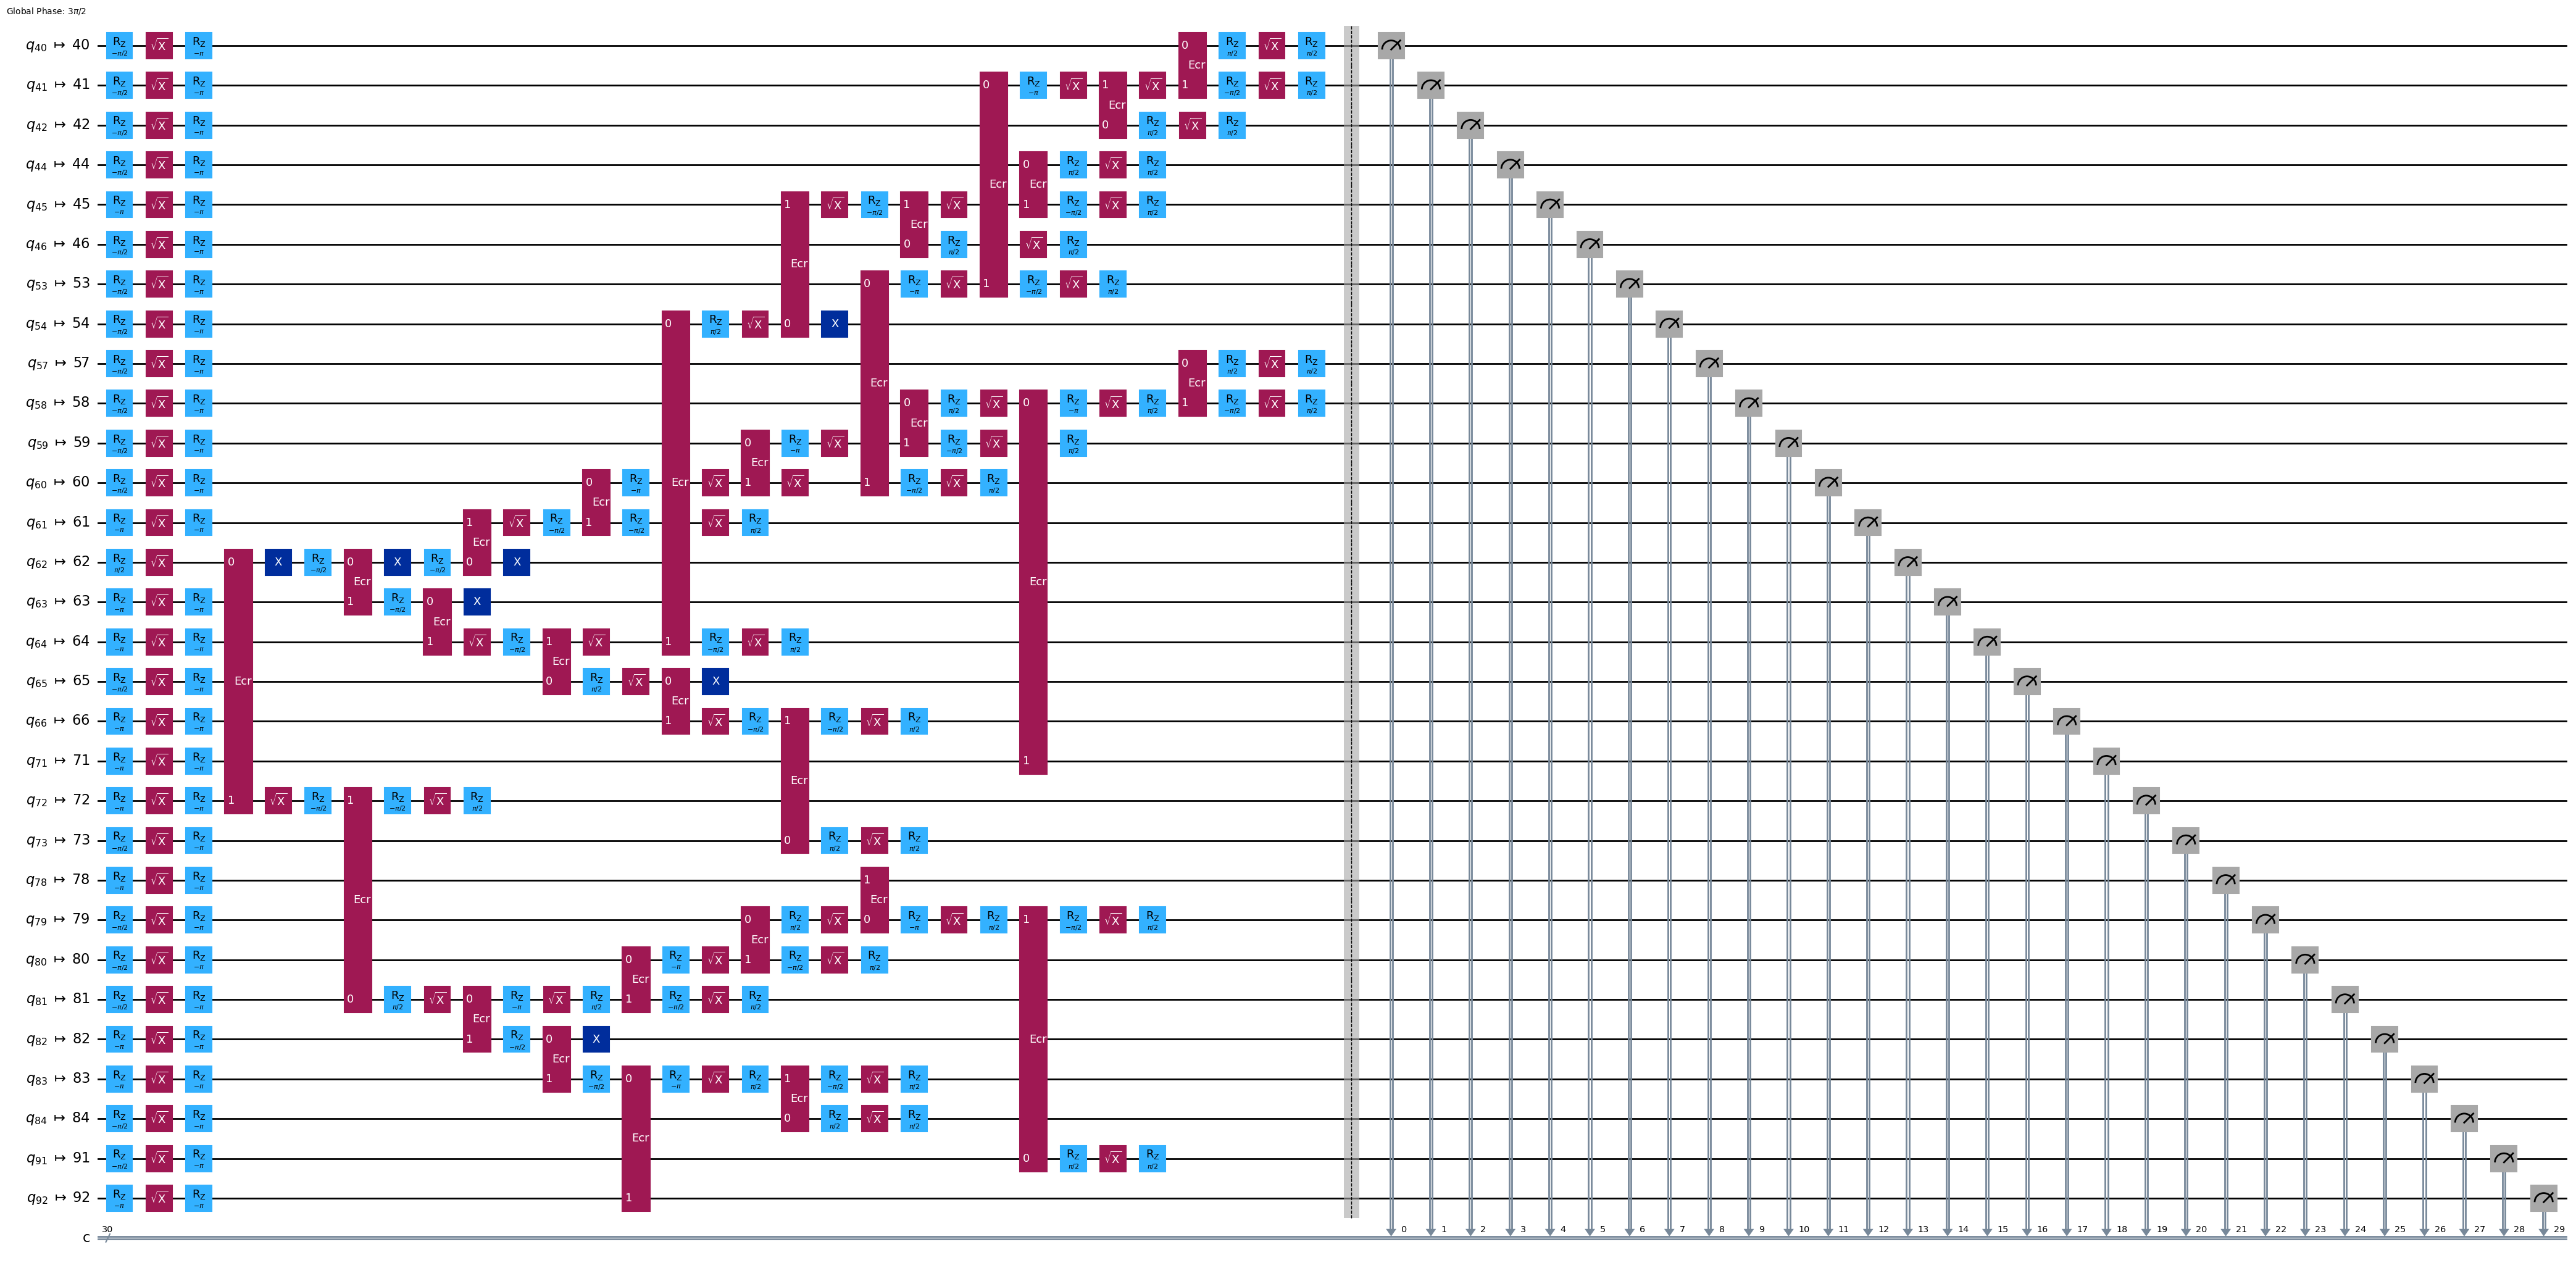

In [56]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz3_transpiled = pm.run(ghz3)
ghz3_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [57]:
print("Depth:", ghz3_transpiled.depth())
print(
    "Two-qubit Depth:",
    ghz3_transpiled.depth(filter_function=lambda x: x.operation.num_qubits == 2),
)

Depth: 30
Two-qubit Depth: 9


### 3.2 別のルート・ノードを手動で選択

In [64]:
central = 72

vis = TreeEdgesRecorder(N)
rx.bfs_search(g, [central], vis)
best_qubits = sorted(list(set(q for e in vis.edges for q in (e[0], e[1]))))
print("Qubits selected:", best_qubits)

Qubits selected: [41, 45, 53, 54, 58, 59, 60, 61, 62, 63, 64, 65, 66, 71, 72, 76, 77, 78, 79, 80, 81, 82, 83, 84, 91, 92, 98, 101, 102, 103]


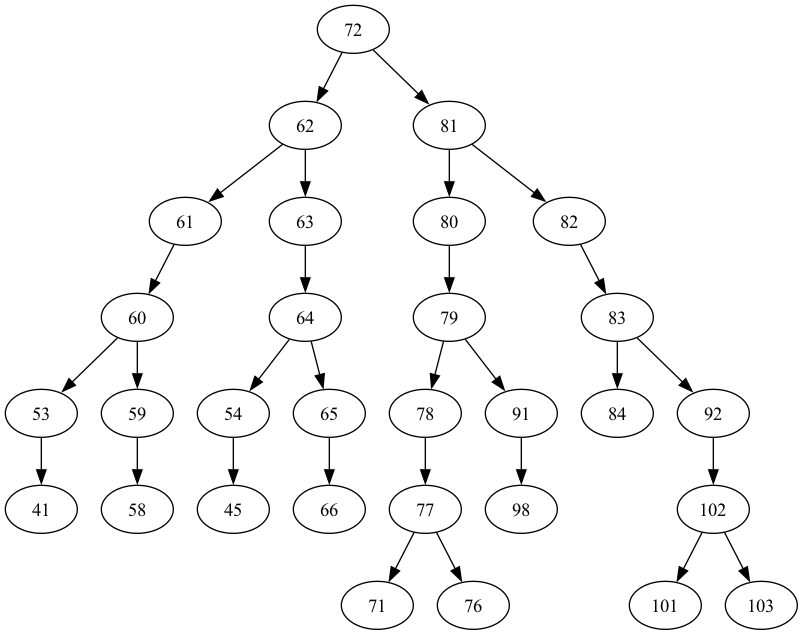

In [65]:
from rustworkx.visualization import graphviz_draw

tree = rx.PyDiGraph()
tree.extend_from_weighted_edge_list(vis.edges)
tree.remove_nodes_from([n for n in range(max(best_qubits) + 1) if n not in best_qubits])

graphviz_draw(tree, method="dot")

このツリーの深さは6です。


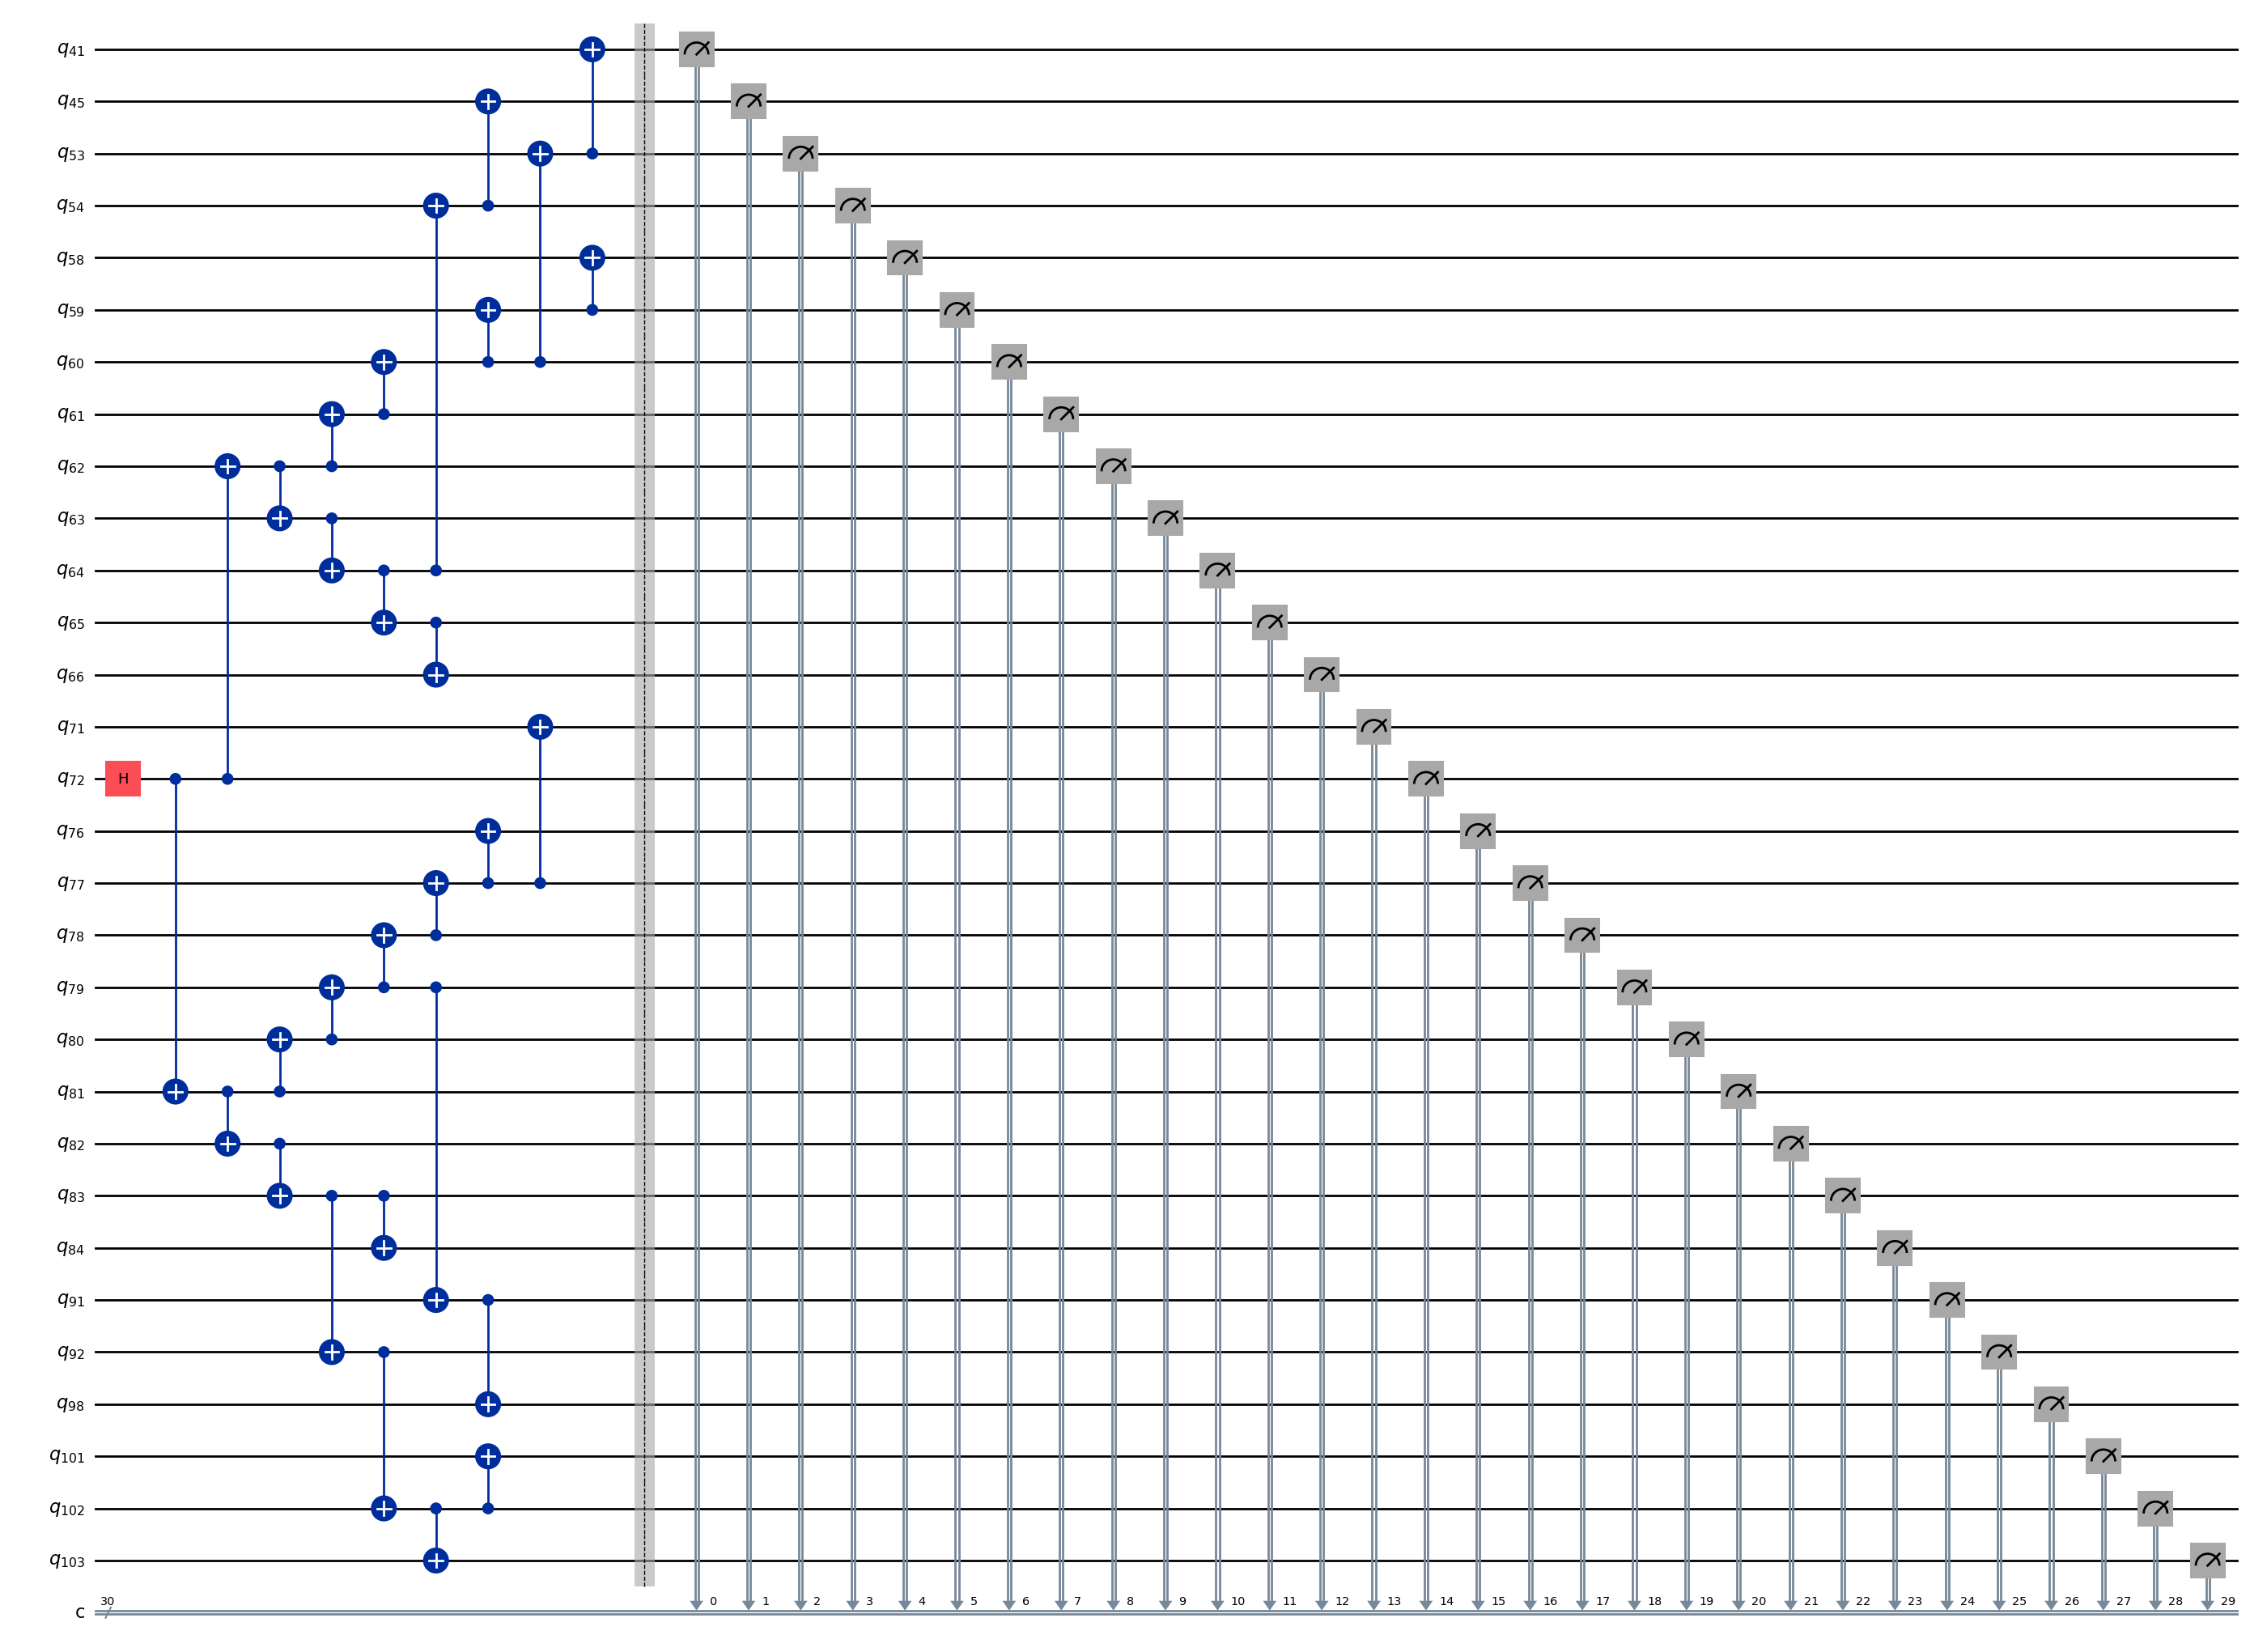

In [66]:
ghz3 = QuantumCircuit(max(best_qubits) + 1, N)

ghz3.h(tree.edge_list()[0][0])  # apply H-gate to the root node
# Apply CNOT from the root node to the each edge.
for u, v in tree.edge_list():
    ghz3.cx(u, v)
ghz3.barrier()  # for visualization
ghz3.measure(best_qubits, list(range(N)))
ghz3.draw(output="mpl", idle_wires=False, fold=-1)

In [67]:
ghz3.depth()

10

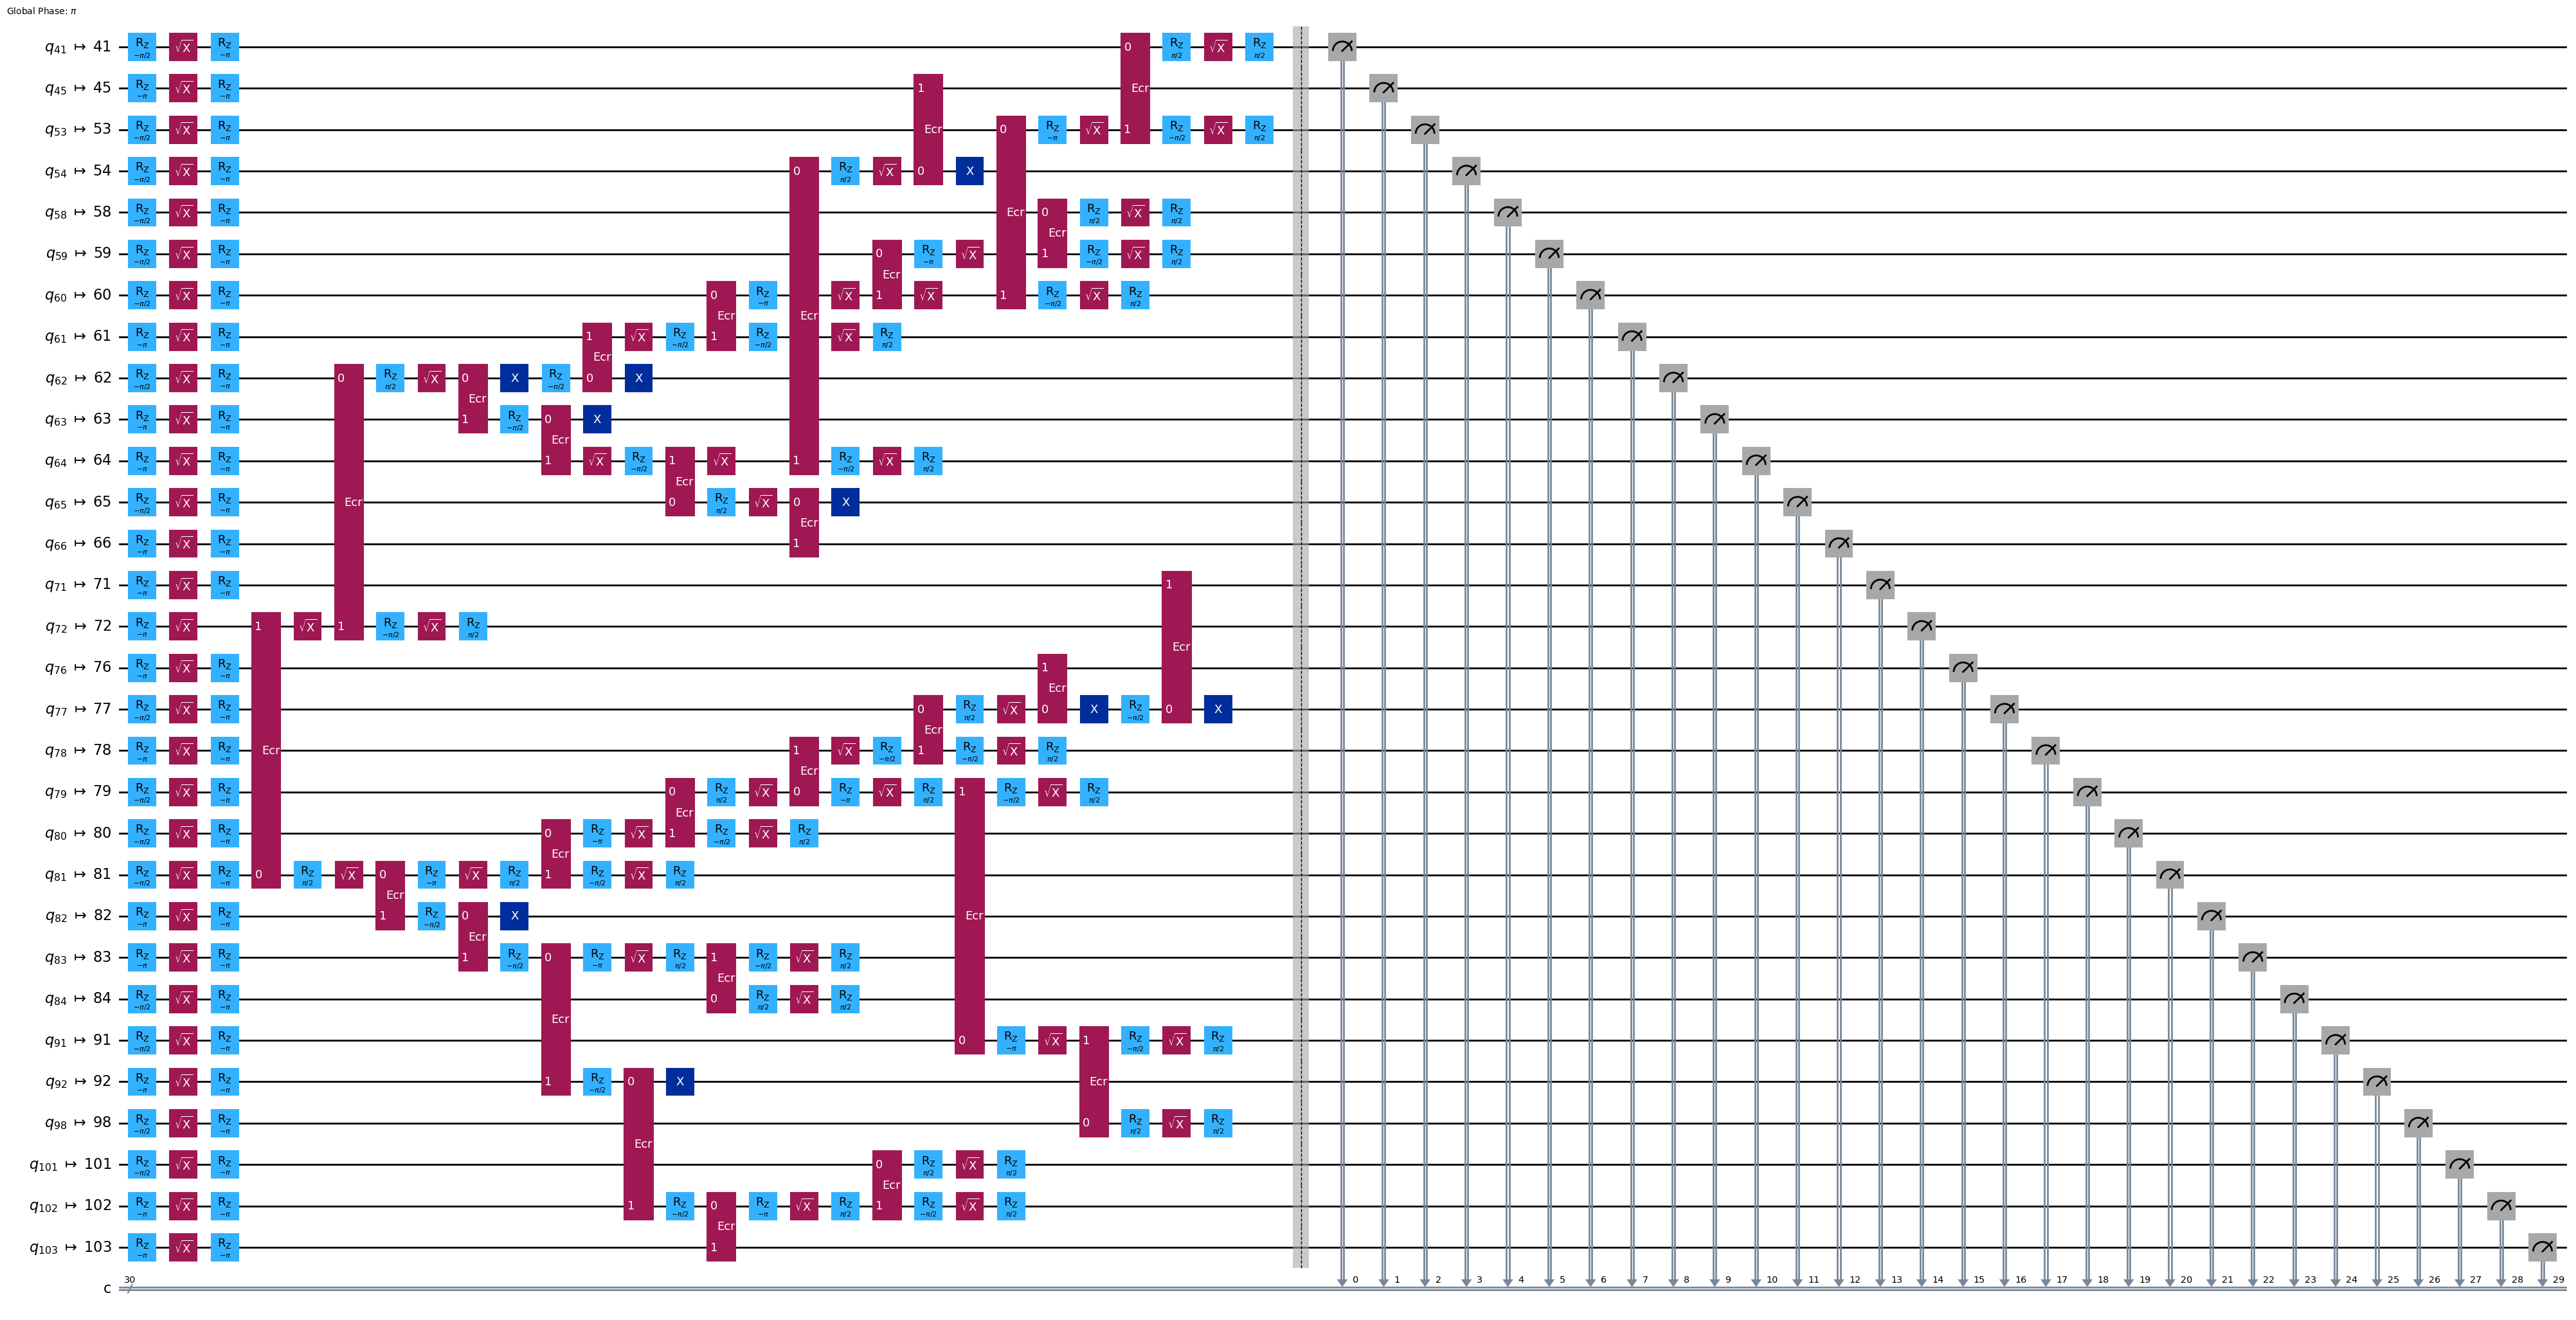

In [68]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz3_transpiled = pm.run(ghz3)
ghz3_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [69]:
print("Depth:", ghz3_transpiled.depth())
print(
    "Two-qubit Depth:",
    ghz3_transpiled.depth(filter_function=lambda x: x.operation.num_qubits == 2),
)

Depth: 28
Two-qubit Depth: 8


驚くべきことに、ツリーの深さは 5 から 6 に増加しましたが、2 量子ビットの深さは 9 から 8 に減少しました。よって、後者の回路を使用してみます。

#### Step 3: ターゲット・ハードウェアで実行

In [70]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz3,
    physical_qubits=best_qubits,
    backend=backend,
    sampler_options=opts,
)

Sampler job id: d3is2a9fk6qs73ekuotg, shots=40000
Estimator job id: d3is2ao3qtks73888rlg


In [72]:
job_s = service.job(res[0])  # Use your job id showed above.
job_e = service.job(res[1])
print(job_s.status(), job_e.status())

DONE DONE


#### Step 4: 結果の後処理

In [73]:
N = 30
# Check fidelity from job IDs
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

N=30: |00..0>: 9, |11..1>: 24, |3rd>: 867 (000100000100000100000000000000)
P(|00..0>)=0.000225, P(|11..1>)=0.0006
REM: Coherence (non-diagonal): -0.009830
GHZ fidelity = -0.004502 ± 0.003860
GME (genuinely multipartite entangled) test: Failed


ご覧の通り、この結果はクライテリアを満たしません。

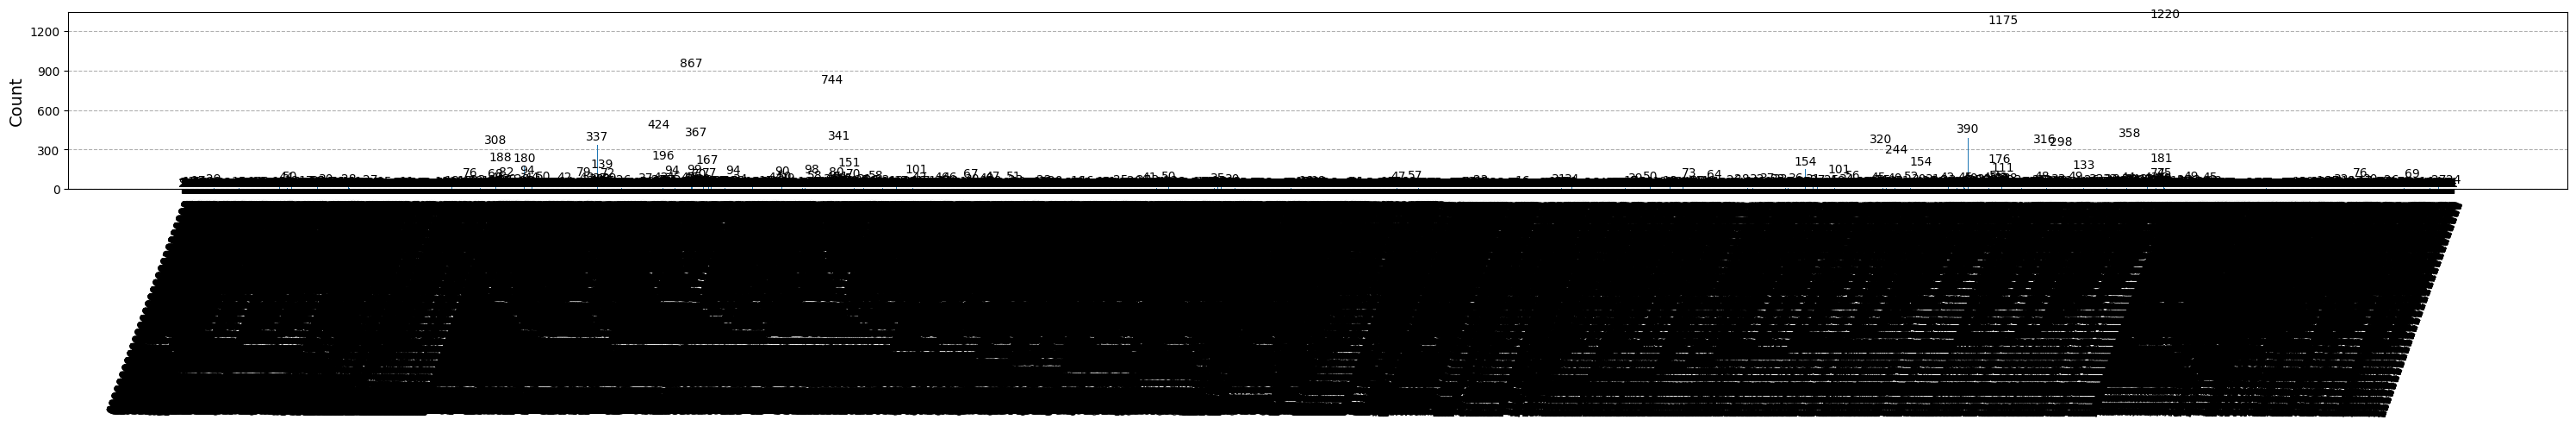

In [74]:
# It will take some time
result = job_s.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

## 4. 戦略 3. エラー抑制オプションを使って実行する

Sampler V2では、エラー抑制オプションが設定できます。詳しくは、 ガイドの [エラー緩和の設定](https://quantum.cloud.ibm.com/docs/en/guides/configure-error-mitigation#advanced-error) および ['ExecutionOptionsV2'](https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/options-execution-options-v2) API リファレンスを参照してください。


In [75]:
opts = SamplerOptions()
opts.twirling.enable_gates=False
opts.twirling.enable_measure = True
opts.dynamical_decoupling.skip_reset_qubits = True
opts.dynamical_decoupling.enable = True
opts.dynamical_decoupling.sequence_type = "XY4"

In [76]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz3,
    physical_qubits=best_qubits,
    backend=backend,
    sampler_options=opts,
)

Sampler job id: d3is50hfk6qs73ekurj0, shots=40000
Estimator job id: d3is5134kkus738c2msg


In [77]:
job_s = service.job(res[0])  # Use your job id showed above.
job_e = service.job(res[1])
print(job_s.status(), job_e.status())

DONE DONE


In [78]:
N = 30

In [79]:
# Check fidelity from job IDs
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

N=30: |00..0>: 166, |11..1>: 104, |3rd>: 383 (000100000000000000000000000010)
P(|00..0>)=0.00415, P(|11..1>)=0.0026
REM: Coherence (non-diagonal): -0.014548
GHZ fidelity = -0.003899 ± 0.004156
GME (genuinely multipartite entangled) test: Failed


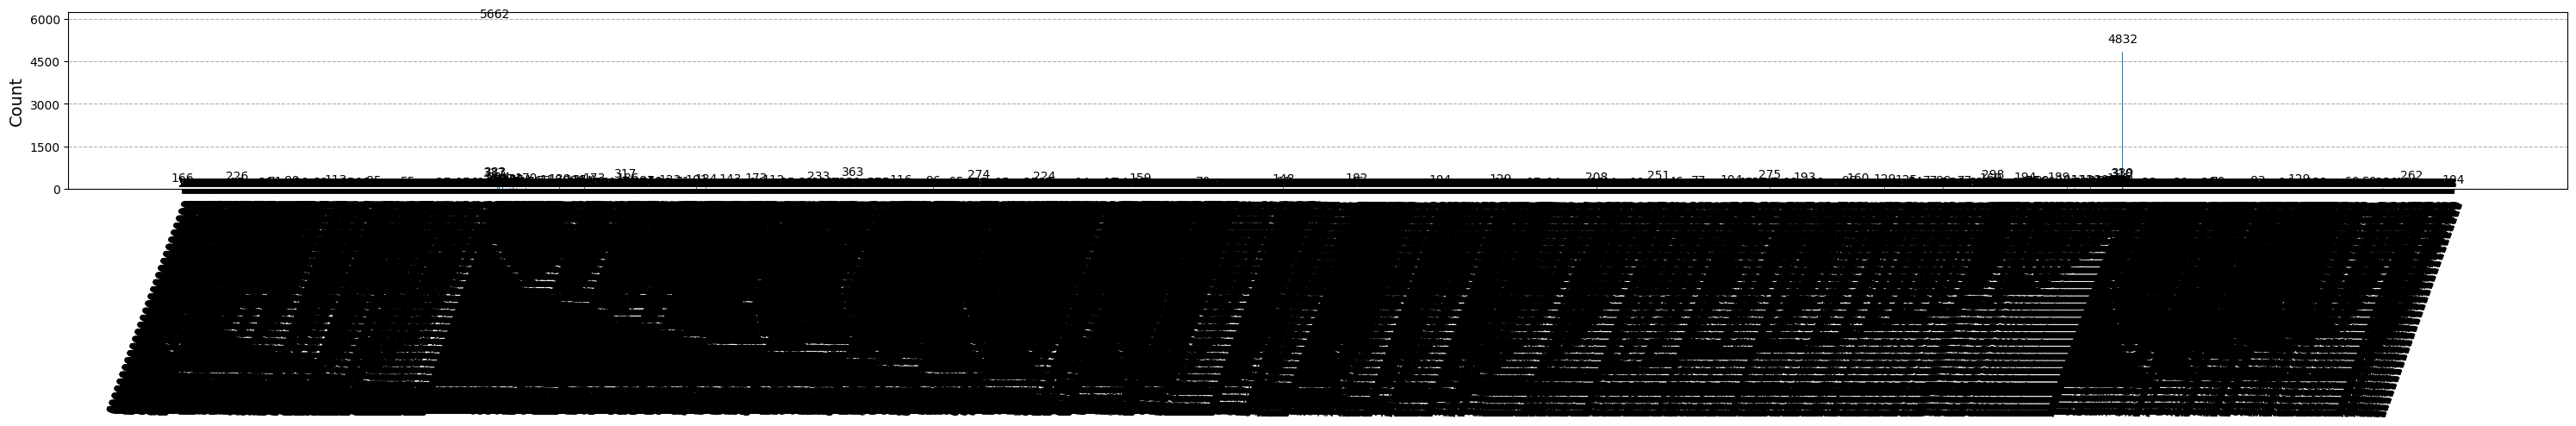

In [80]:
# It will take some time
result = job_s.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

結果は改善されましたが、まだ基準を満たしていません。

これまでに3つのアイデアを見てきました。これらのアイデアを組み合わせて拡張することも、独自のアイデアでより良い GHZ 回路を作成することもできます。それでは、もう一度目標を確認します。

###  5. 目標 (再度)

20 量子ビット以上の GHZ 回路を構築して、測定時に **GHZ 状態の忠実度が0.5より大きくなるように** します。
Note:

*   Eagle デバイス (たとえば `ibm_brisbane`) を使用し、ショット数を40,000に設定する必要があります。
*   GHZ 回路の実行は `execute_ghz_fidelity` 関数で行い、忠実度は `check_ghz_fidelity_from_jobs` 関数で計算してください。

クライテリアを満たす最大の量子ビットの GHZ 回路を見つける必要があります。

最後に、Heronデバイスに、さきほどと同じ GHZ ワークフローを実装します。これにより、Heronプロセッサーのレイアウトと機能についてある程度の経験が得られます。新しい戦略は導入されません。

*この次の実験を実行するためのおおよその QPU 時間は 4 分 40 秒です。*

In [6]:
service = QiskitRuntimeService(name="premium")
backend = service.backend("ibm_kingston")

twoq_gate = "cz"
print(f"Device {backend.name} Loaded with {backend.num_qubits} qubits")
print(f"Two Qubit Gate: {twoq_gate}")

Device ibm_kingston Loaded with 156 qubits
Two Qubit Gate: cz


In [7]:
BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_CZGATE_ERROR_THRESHOLD = 0.1
bad_readout_qubits = [
    q
    for q in range(backend.num_qubits)
    if backend.target["measure"][(q,)].error > BAD_READOUT_ERROR_THRESHOLD
]
bad_czgate_edges = [
    qpair
    for qpair in backend.target["cz"]
    if backend.target["cz"][qpair].error > BAD_CZGATE_ERROR_THRESHOLD
]
print("Bad readout qubits:", bad_readout_qubits)
print("Bad CZ gates:", bad_czgate_edges)

Bad readout qubits: [112, 113, 120, 131, 146]
Bad CZ gates: [(111, 112), (112, 111), (112, 113), (113, 112), (113, 114), (113, 119), (114, 113), (119, 113), (120, 121), (121, 120), (130, 131), (131, 130), (145, 146), (146, 145), (146, 147), (147, 146)]


In [8]:
g = backend.coupling_map.graph.copy().to_undirected()
g.remove_edges_from(
    bad_czgate_edges
)  # remove edge first (otherwise might fail with a NoEdgeBetweenNodes error)
g.remove_nodes_from(bad_readout_qubits)

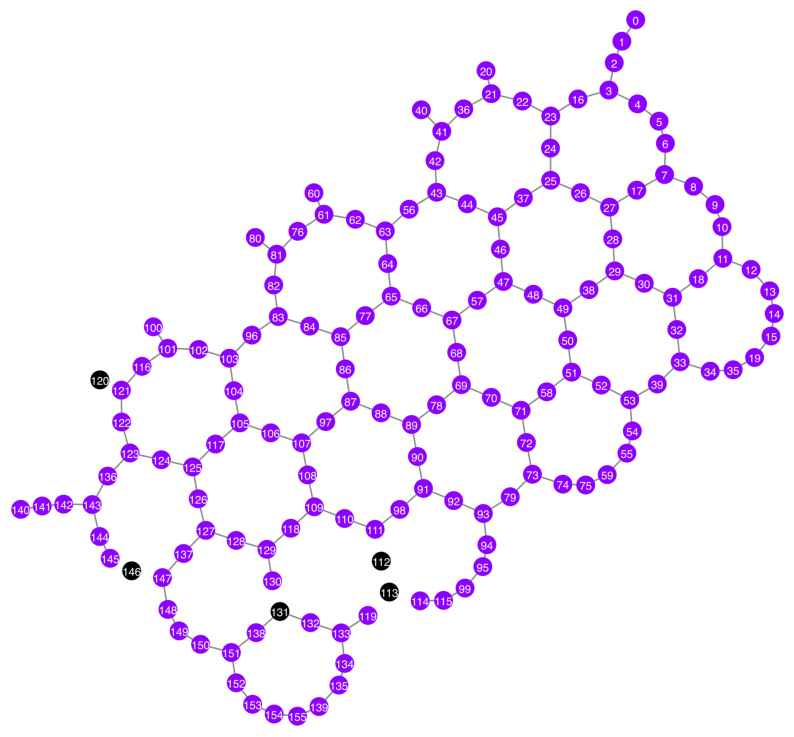

In [9]:
qubit_color = []
for i in range(backend.num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000")  # black
    else:
        qubit_color.append("#8c00ff")  # purple
line_color = []
for e in backend.target.build_coupling_map().get_edges():
    if e in bad_czgate_edges:
        line_color.append("#ffffff")  # white
    else:
        line_color.append("#888888")  # gray
plot_gate_map(
    backend,
    qubit_color=qubit_color,
    line_color=line_color,
    qubit_size=60,
    font_size=30,
    figsize=(10, 10),
)

In [14]:
N = 40
central = 48  # Select the center node manually
# c_degree = dict(rx.betweenness_centrality(g))
# central = max(c_degree, key=c_degree.get)
# central

In [15]:
class TreeEdgesRecorder(rx.visit.BFSVisitor):
    def __init__(self, N):
        self.edges = []
        self.N = N

    def tree_edge(self, edge):
        self.edges.append(edge)
        if len(self.edges) >= self.N - 1:
            raise rx.visit.StopSearch()


vis = TreeEdgesRecorder(N)
rx.bfs_search(g, [central], vis)
best_qubits = sorted(list(set(q for e in vis.edges for q in (e[0], e[1]))))
print("Qubits selected:", best_qubits)

Qubits selected: [17, 18, 25, 26, 27, 28, 29, 30, 31, 32, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 64, 65, 66, 67, 68, 69, 70, 71, 72, 77, 78]


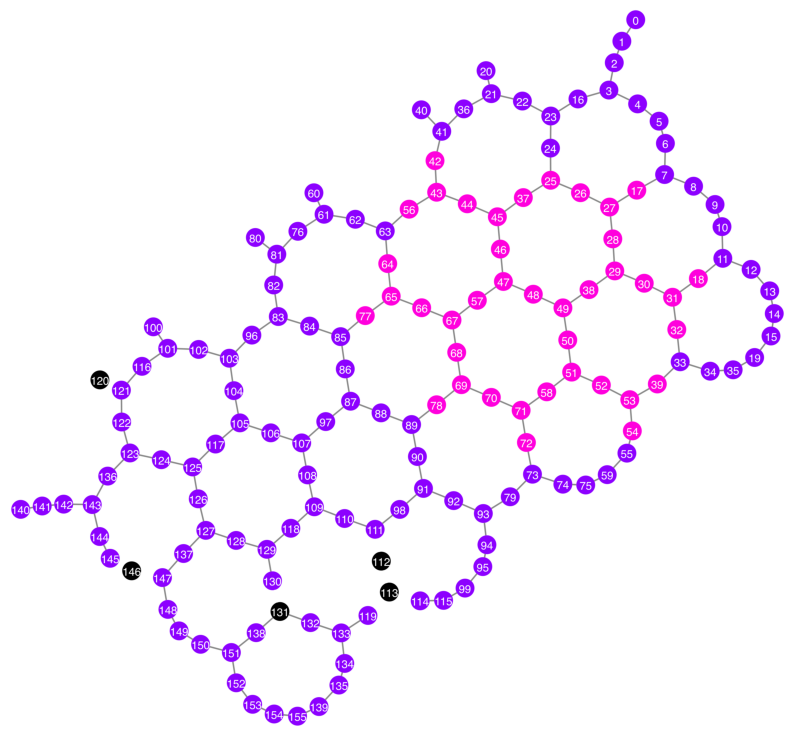

In [16]:
qubit_color = []
for i in range(backend.num_qubits):
    if i in bad_readout_qubits:
        qubit_color.append("#000000")
    elif i in best_qubits:
        qubit_color.append("#ff00dd")
    else:
        qubit_color.append("#8c00ff")
line_color = []
for e in backend.target.build_coupling_map().get_edges():
    if e in bad_czgate_edges:
        line_color.append("#ffffff")
    else:
        line_color.append("#888888")
plot_gate_map(
    backend,
    qubit_color=qubit_color,
    line_color=line_color,
    qubit_size=60,
    font_size=30,
    figsize=(10, 10),
)

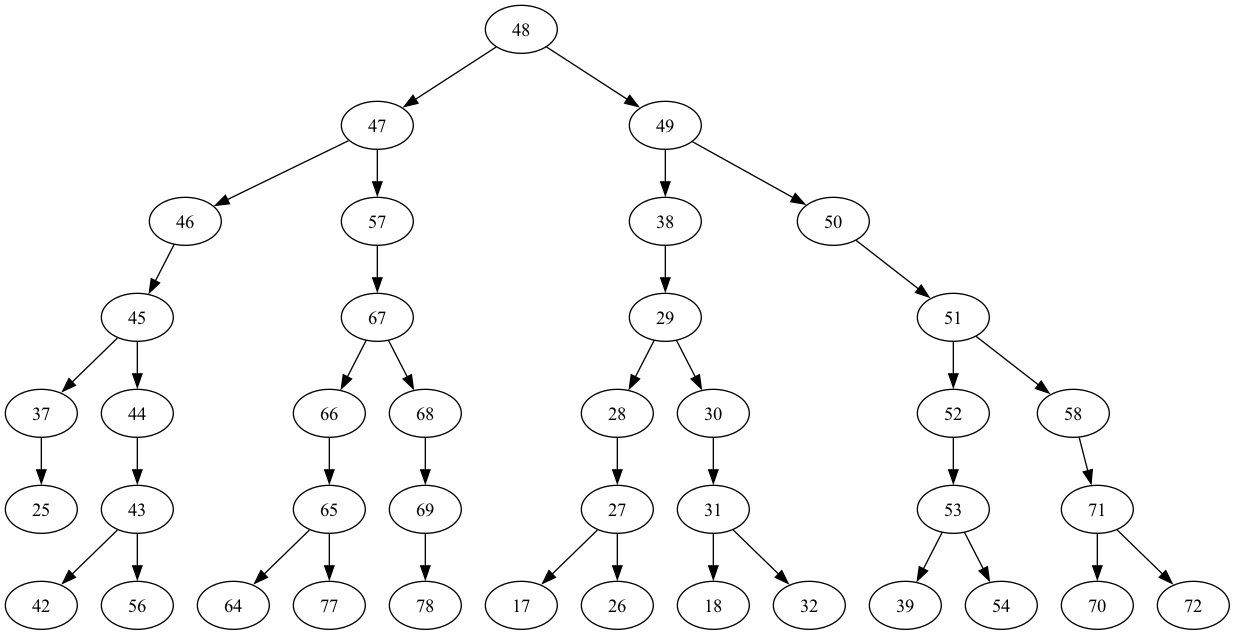

In [17]:
from rustworkx.visualization import graphviz_draw

tree = rx.PyDiGraph()
tree.extend_from_weighted_edge_list(vis.edges)
tree.remove_nodes_from([n for n in range(max(best_qubits) + 1) if n not in best_qubits])

graphviz_draw(tree, method="dot")

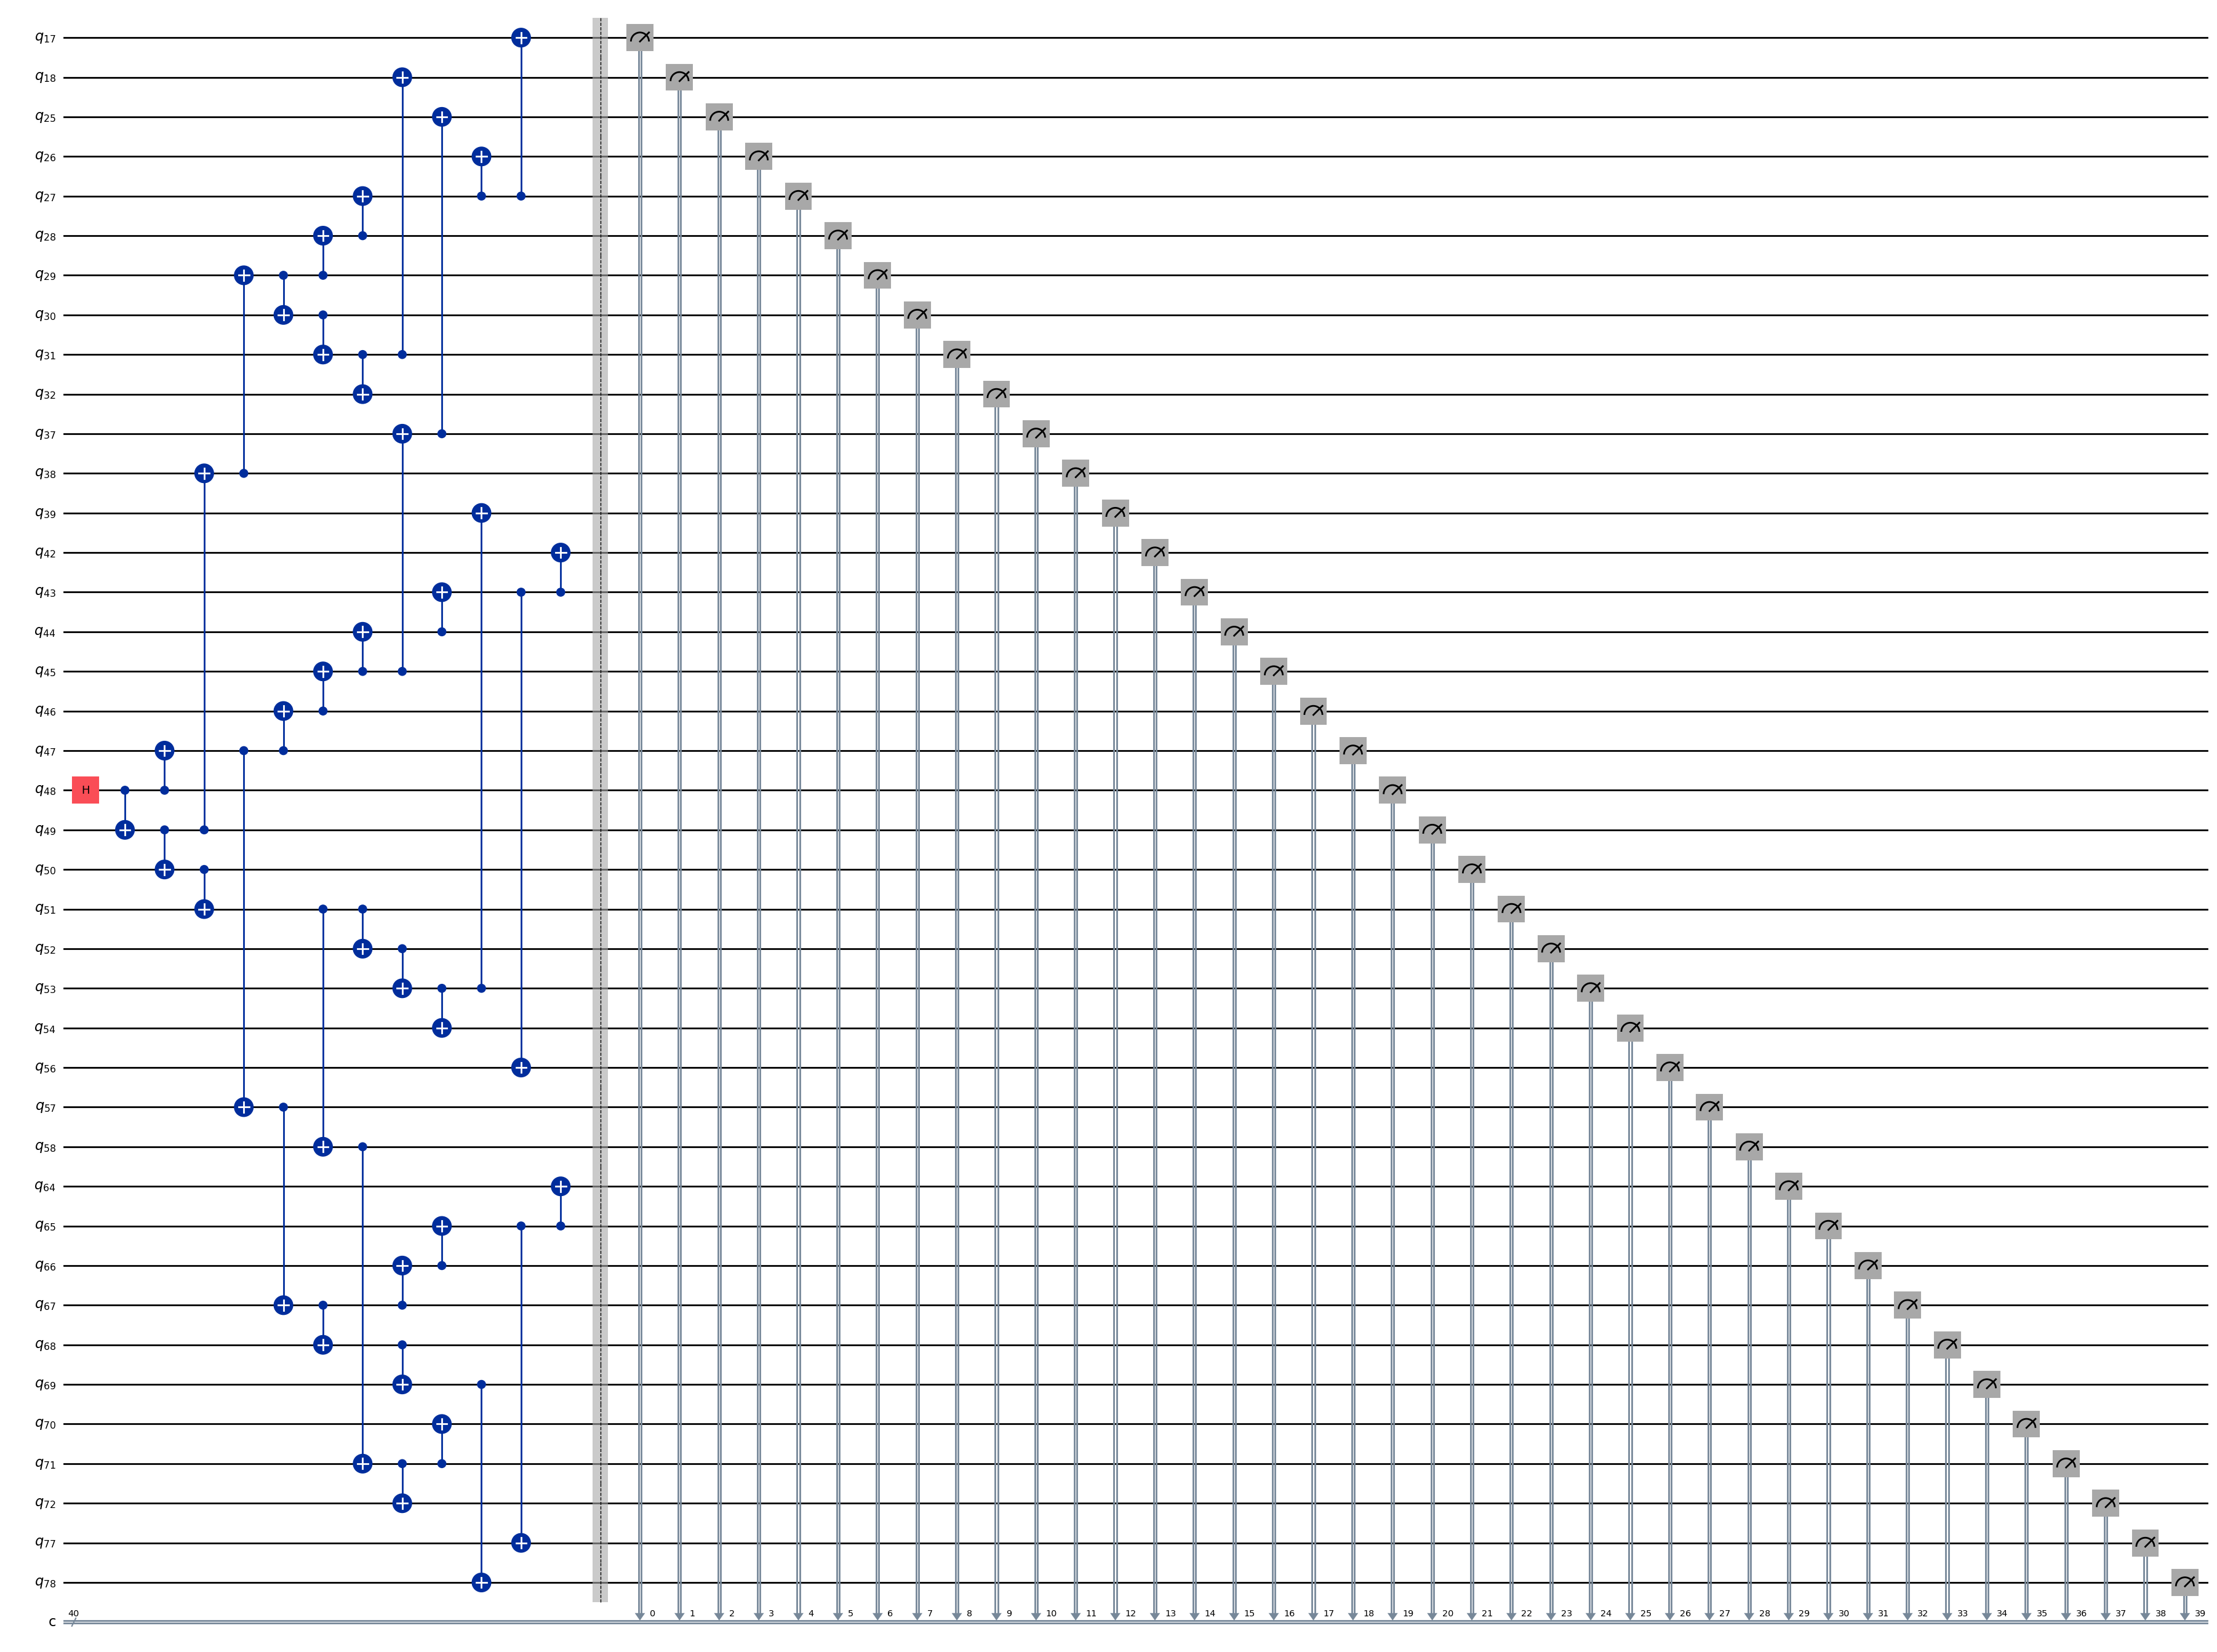

In [18]:
ghz_h = QuantumCircuit(max(best_qubits) + 1, N)

ghz_h.h(tree.edge_list()[0][0])  # apply H-gate to the root node
# Apply CNOT from the root node to the each edge.
for u, v in tree.edge_list():
    ghz_h.cx(u, v)
ghz_h.barrier()  # for visualization
ghz_h.measure(best_qubits, list(range(N)))
ghz_h.draw(output="mpl", idle_wires=False, fold=-1)

In [19]:
ghz_h.depth()

11

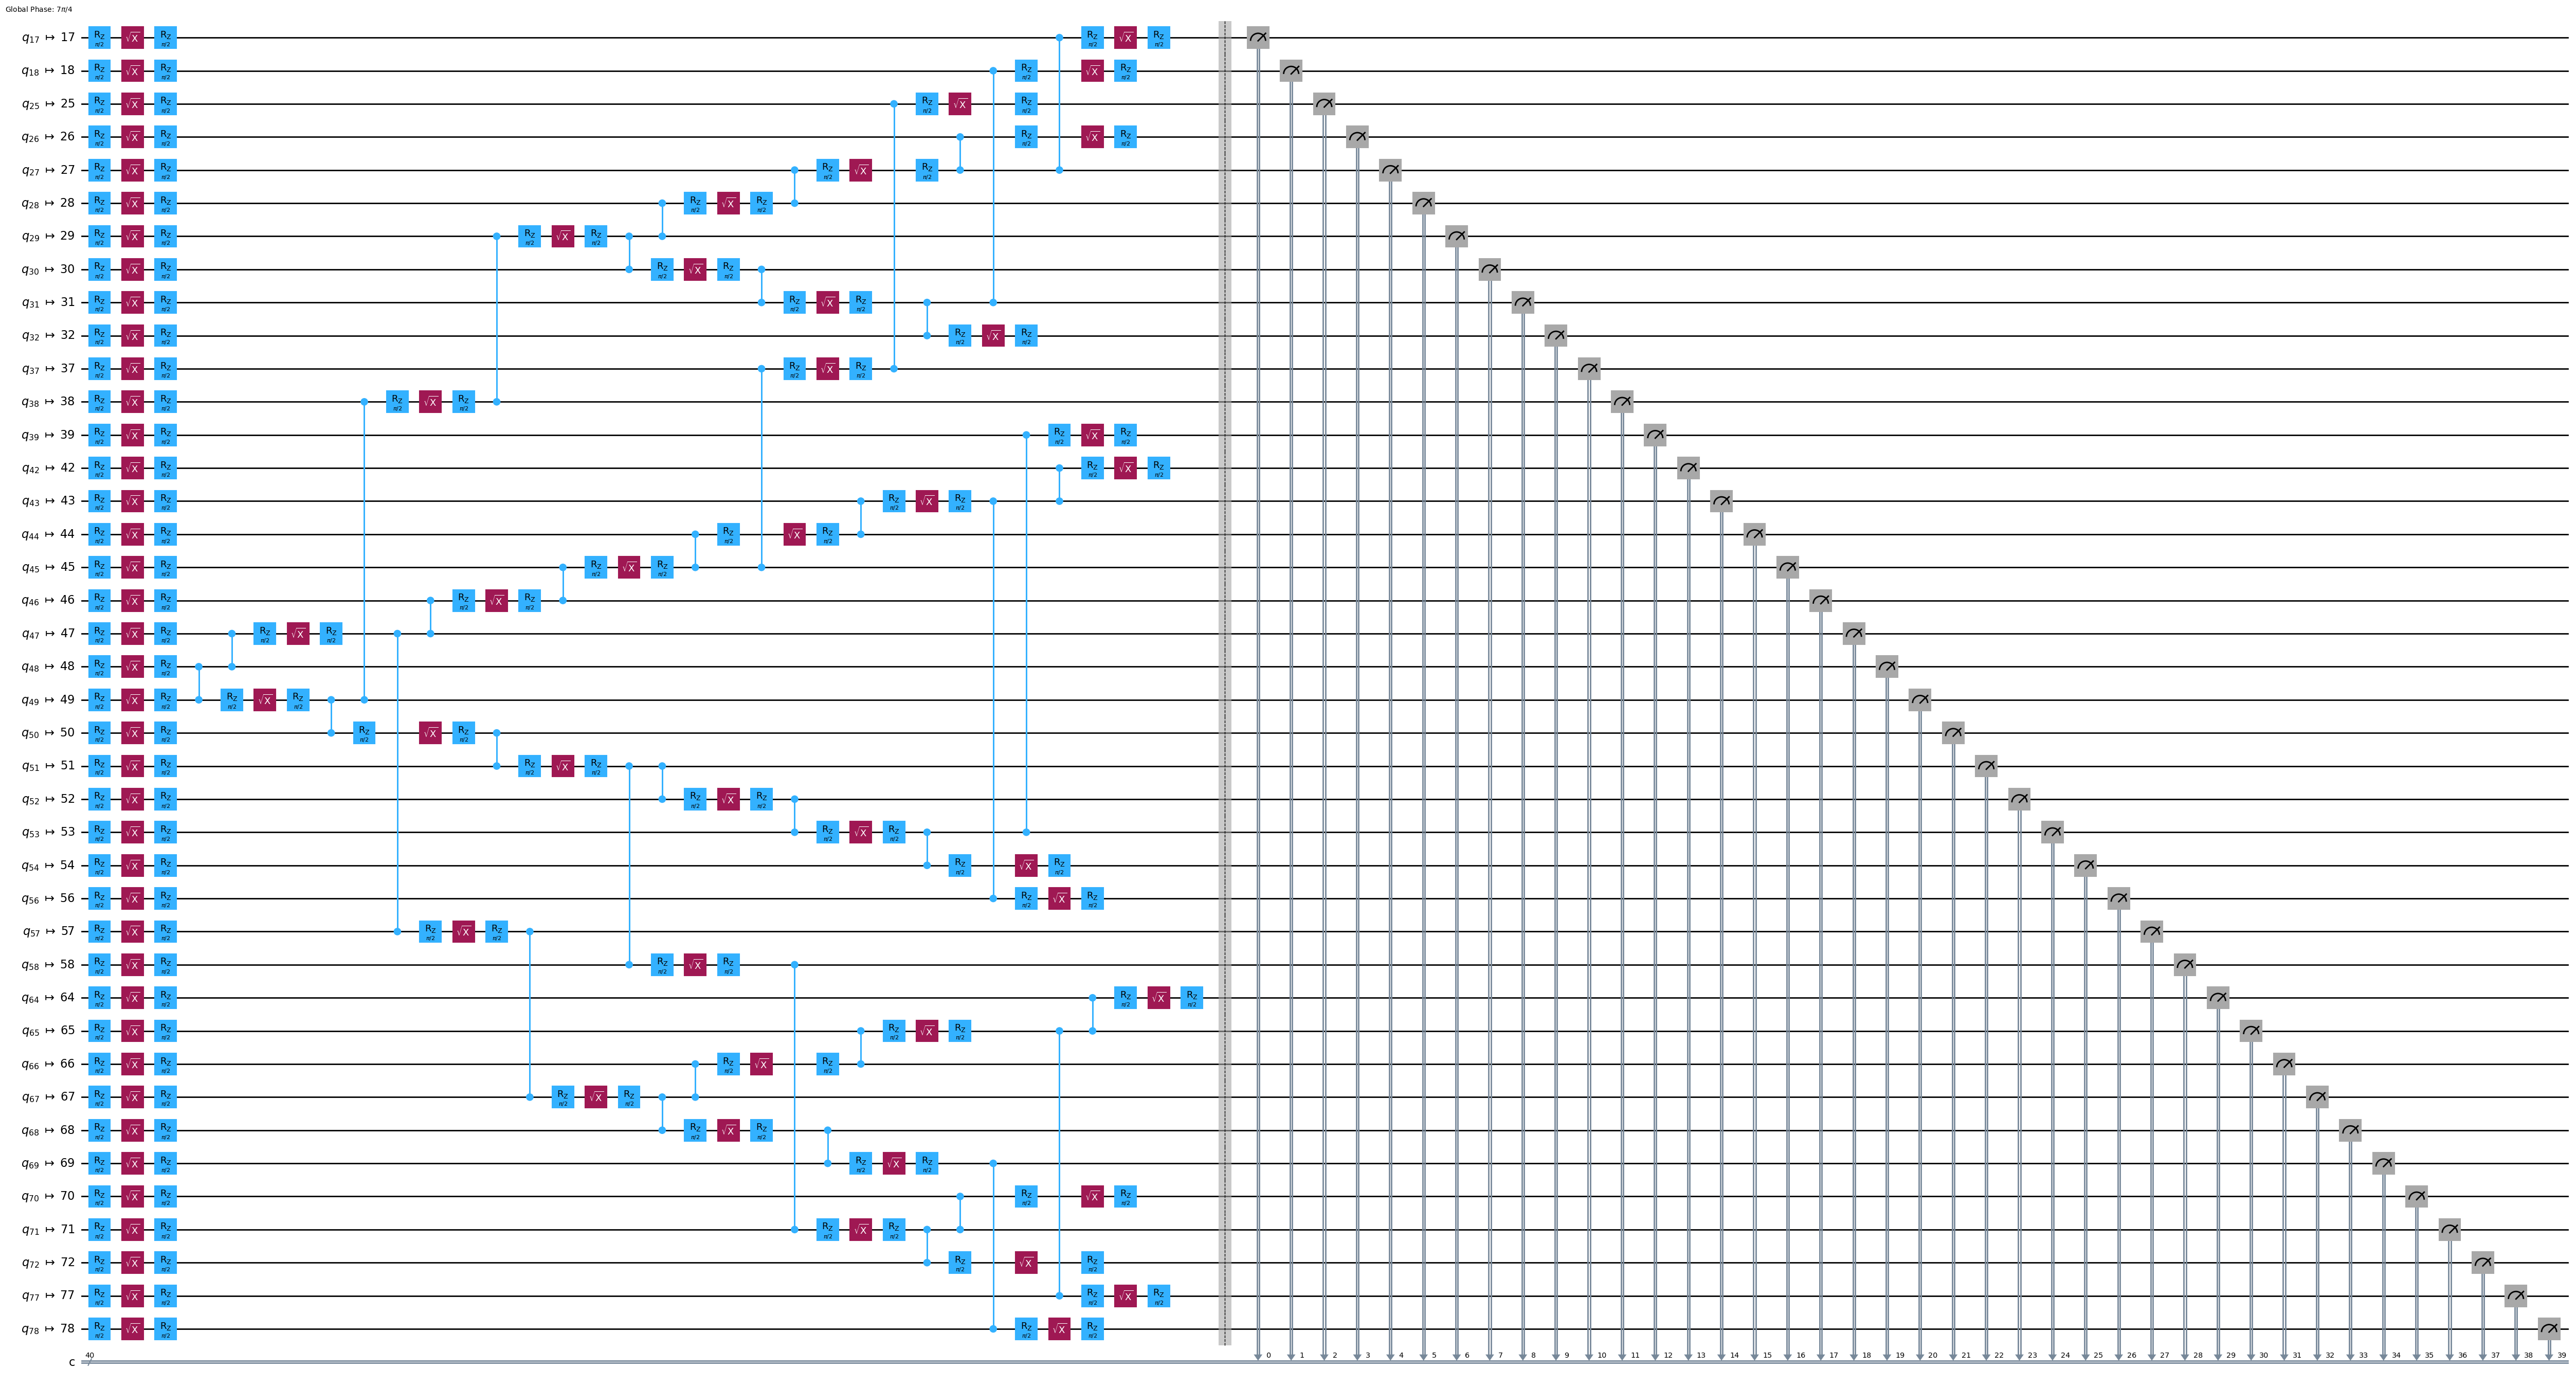

In [20]:
pm = generate_preset_pass_manager(1, backend=backend)
ghz_h_transpiled = pm.run(ghz_h)
ghz_h_transpiled.draw(output="mpl", idle_wires=False, fold=-1)

In [21]:
print("Depth:", ghz_h_transpiled.depth())
print(
    "Two-qubit Depth:",
    ghz_h_transpiled.depth(filter_function=lambda x: x.operation.num_qubits == 2),
)

Depth: 31
Two-qubit Depth: 9


In [22]:
opts = SamplerOptions()
opts.dynamical_decoupling.enable = True
opts.execution.rep_delay = 0.0005
opts.twirling.enable_gates = True

In [26]:
res = execute_ghz_fidelity(
    ghz_circuit=ghz_h,
    physical_qubits=best_qubits,
    backend=backend,
    sampler_options=opts,
)

Sampler job id: d3iscub4kkus738c2uhg, shots=40000
Estimator job id: d3iscuo3qtks7388969g


In [27]:
job_s = service.job(res[0])  # Use your job id showed above.
job_e = service.job(res[1])
print(job_s.status(), job_e.status())

DONE DONE


In [28]:
# Check fidelity from job IDs
N = 40
res = check_ghz_fidelity_from_jobs(
    sampler_job=job_s,
    estimator_job=job_e,
    num_qubits=N,
)

N=40: |00..0>: 3275, |11..1>: 3167, |3rd>: 3275 (0000000000000000000000000000000000000000)
P(|00..0>)=0.081875, P(|11..1>)=0.079175
REM: Coherence (non-diagonal): 0.009702
GHZ fidelity = 0.085376 ± 0.001965
GME (genuinely multipartite entangled) test: Failed


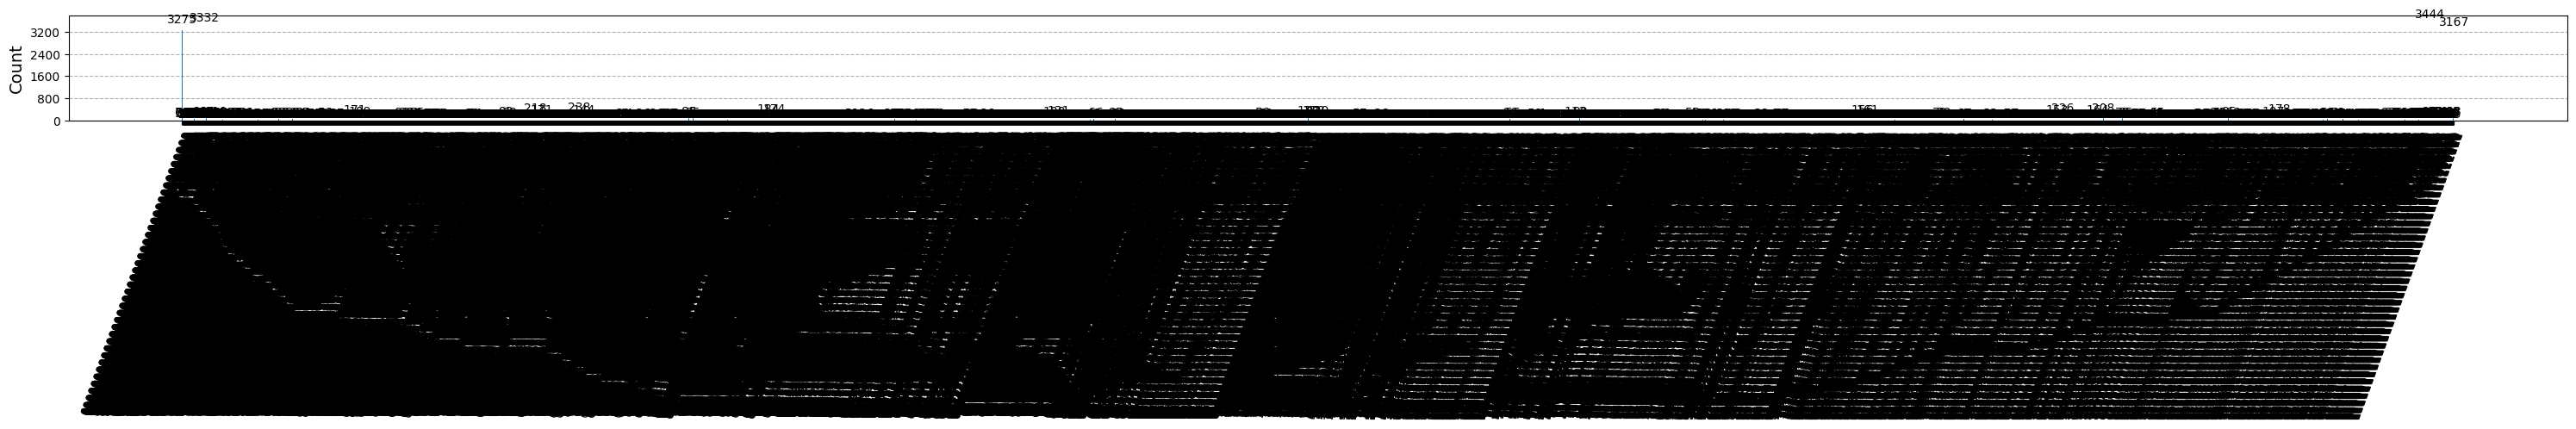

In [29]:
# It will take some time
result = job_s.result()
plot_histogram(result[0].data.c.get_counts(), figsize=(30, 5))

おめでとうございます！これで、ユーティリティー・スケールの量子コンピューティングの入門が完了しました。あなたは今、量子的優位性の探求に有意義な貢献をする準備ができています! IBM Quantum® をあなたの量子の旅の一部にしていただきありがとうございます。

© IBM Corp., 2017-2025